#  Problem Statement


### Once a patient seems to have a problem related to tumors, the tumor will be examined and the genetic sequence will be done on the same. From that we get the genes and also the mutations which can cause cancer.

### So every gene has a name  or ID associated with it, so we have gene and variation associated with it.

### Given a Gene ID, variation, a pathologist does research the available literature corresponding to the gene and variation. The pathologist analyzes the text, gene, variations and classify the cancer type.

# Business Objective

### So here we have to build a machine learning model that could classify the cancer type given that Gene, Variation and Text data associated to it.

### The business constraints we have is

### 1. Very Limited Data
### 2. Performance Metric- Multi class log loss

# Exploratory Data Analysis

In [ ]:
import pandas as pd
import re
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn
import warnings
import mlxtend
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier



# Reading Data
## Reading Gene and Variation Data

In [ ]:
data = pd.read_csv("/content/training_variants")

In [ ]:
data.shape

(3321, 4)

In [ ]:
data.head()


ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

In [ ]:
data_text = pd.read_csv("/content/training_text",sep="\|\|",
                        engine ="python", names=["ID", "TEXT"], skiprows=1)

In [ ]:
data_text.shape

(3321, 2)

# Text Preprocessing

In [ ]:
# Repalcing multiple spaces in Gene and Variations data
data.Gene = data.Gene.str.replace('\s+', ' ')
data.Variation = data.Variation.str.replace('\s+', ' ')

In [ ]:
stop_words= stopwords.words('english')

In [ ]:
def text_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string= ""
        total_text = re.sub('[^a-zA-Z0-9\n]',' ', total_text) #replacing every special character with space
        total_text = re.sub('\s+', ' ', total_text) #replacing multiple spaces with single space
        total_text = total_text.lower() # Converting the text to lower case
        for word in total_text.split():
            if not word in stop_words:
                string+=word + " "
        data_text[column][index]=string



In [ ]:
for i, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        text_preprocessing(row['TEXT'], i, 'TEXT')
    else:
        print("there is no text for the given id : ", i)



there is no text for the given id :  1109
there is no text for the given id :  1277
there is no text for the given id :  1407
there is no text for the given id :  1639
there is no text for the given id :  2755


In [ ]:
data_text.head()

ID                                               TEXT
0   0  cyclin dependent kinases cdks regulate variety...
1   1  abstract background non small cell lung cancer...
2   2  abstract background non small cell lung cancer...
3   3  recent evidence demonstrated acquired uniparen...
4   4  oncogenic mutations monomeric casitas b lineag...

## Merging both the dataframes gene variations and text

In [ ]:
final_df = pd.merge(data, data_text, on ='ID', how ='left')

In [ ]:
final_df.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...

In [ ]:
final_df[final_df.isnull().any(axis=1)]

ID    Gene             Variation  Class TEXT
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN

### Repalcing text that has null values with Gene and variation

In [ ]:
final_df.loc[final_df['TEXT'].isnull(), 'TEXT'] =final_df['Gene'] + ' ' + final_df['Variation']

In [ ]:
final_df[final_df['ID'].isin([1109,1277,1407,1639,2755])]

ID    Gene             Variation  Class                         TEXT
1109  1109   FANCA                S1088F      1                 FANCA S1088F
1277  1277  ARID5B  Truncating Mutations      1  ARID5B Truncating Mutations
1407  1407   FGFR3                 K508M      6                  FGFR3 K508M
1639  1639    FLT1         Amplification      6           FLT1 Amplification
2755  2755    BRAF                 G596C      7                   BRAF G596C

In [ ]:
print(f"Total Unique Genes: {final_df['Gene'].nunique()}")
print(final_df['Gene'].value_counts())

Total Unique Genes: 264
Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
RYBP        1
MDM2        1
CTLA4       1
ARID1A      1
FAM58A      1
Name: count, Length: 264, dtype: int64


From the above results, we see that we have 264 unique genes  and few genes are present only once, so when the data is split, there is a chance that a gene that is present in test data might not be in train data. This could potentially lead to overfitting when this feature is alone used for Classification.

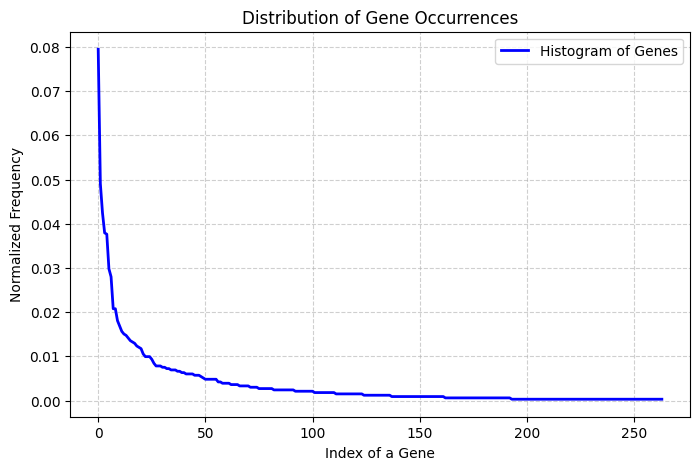

In [ ]:
normalized_gene_counts = final_df['Gene'].value_counts().values / final_df['Gene'].value_counts().values.sum()


plt.figure(figsize=(8, 5))
plt.plot(normalized_gene_counts, label="Histogram of Genes", color="b", linewidth=2)


plt.xlabel("Index of a Gene")
plt.ylabel("Normalized Frequency")
plt.title("Distribution of Gene Occurrences")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)


plt.show()

### From the skewed distribution, we say that only very genes have high frequency of occurences, rest all occured only once.

In [ ]:
print(f"Total Unique Variations: {final_df['Variation'].nunique()}")
print(final_df['Variation'].value_counts().head(10))

Total Unique Variations: 2996
Variation
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
Q61L                     3
E17K                     3
T58I                     3
Q61R                     3
Name: count, dtype: int64


### From the above results, we see that we have 2996 variations, and when the data is split, there is chance that a variation that is present in test data might not be in train data. This could potentially lead to overfitting when this feature is alone used for Classification.

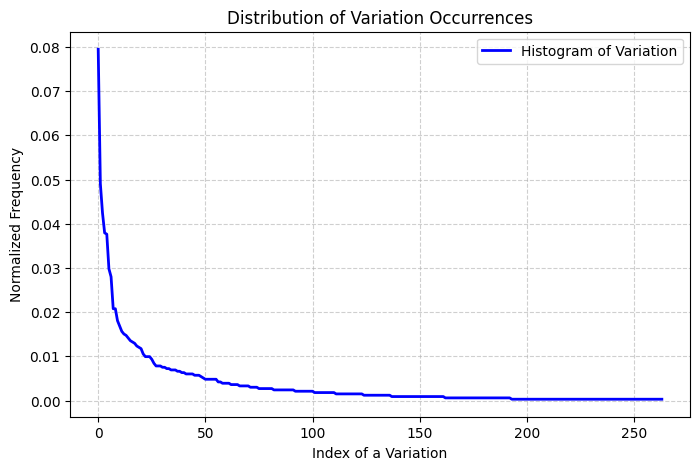

In [ ]:
normalized_Variation_counts = final_df['Variation'].value_counts().values / final_df['Variation'].value_counts().values.sum()


plt.figure(figsize=(8, 5))
plt.plot(normalized_gene_counts, label="Histogram of Variation", color="b", linewidth=2)


plt.xlabel("Index of a Variation")
plt.ylabel("Normalized Frequency")
plt.title("Distribution of Variation Occurrences")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)


plt.show()

### The Variations too followed a skewed distribution, we say that only very genes have high frequency of occurences, rest all occured only once.

# Data Preparation

## Train Test split

### Splitting data into train, test and cross validation (64:20:16)

In [ ]:
y_true = final_df['Class'].values

#split the data into test and train by maintaining same distribution of output variable 'y_true' [stratify = y_true]
X_train, test_df, y_train, y_test = train_test_split(final_df, y_true, stratify = y_true, test_size = 0.2)
# split the train data into train and cross validation by maintaining same distribution of output variable 'y_trian' [stratify = y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify = y_train, test_size =0.2)

In [ ]:
train_df.shape

(2124, 5)

In [ ]:
y_train.shape

(2124,)

In [ ]:
test_df.shape

(665, 5)

In [ ]:
cv_df.shape


(532, 5)

In [ ]:
print("Number of data points in train data: ", train_df.shape[0])

Number of data points in train data:  2124


In [ ]:
print("NUmber of data points in CV data : ",cv_df.shape[0])
print("NUmber of data points in test data : ",test_df.shape[0])

NUmber of data points in CV data :  532
NUmber of data points in test data :  665


# Distribution of Class labels in train, test, CV datasets.

In [ ]:
def get_class_distribution(df):
    class_counts = df['Class'].value_counts().sort_index()
    class_percentage = (class_counts / class_counts.sum()) * 100
    return class_percentage

In [ ]:
train_class_distribution = get_class_distribution(train_df)
cv_class_distribution = get_class_distribution(cv_df)
test_class_distribution = get_class_distribution(test_df)

In [ ]:
#Plots class distribution as a bar chart.

def plot_class_distribution(class_distribution, dataset_name):
    """Plots the percentage distribution of class labels with value annotations."""
    ax = class_distribution.plot(kind='bar', color='tab:blue', figsize=(8, 5))

    plt.xlabel('Class')
    plt.ylabel('Percentage of Data Points per Class')
    plt.title(f"Percentage Distribution of y_i's in {dataset_name} Data")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, percentage in enumerate(class_distribution):
        plt.text(i, percentage + 0.5, f"{percentage:.2f}%", ha='center', fontsize=12, fontweight='bold')

    plt.show()

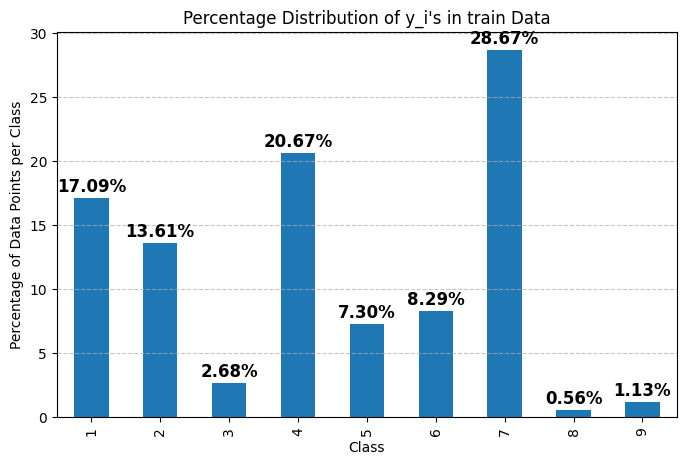

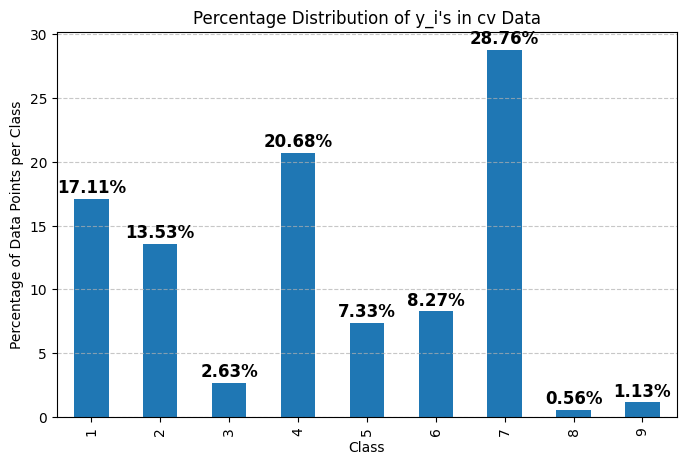

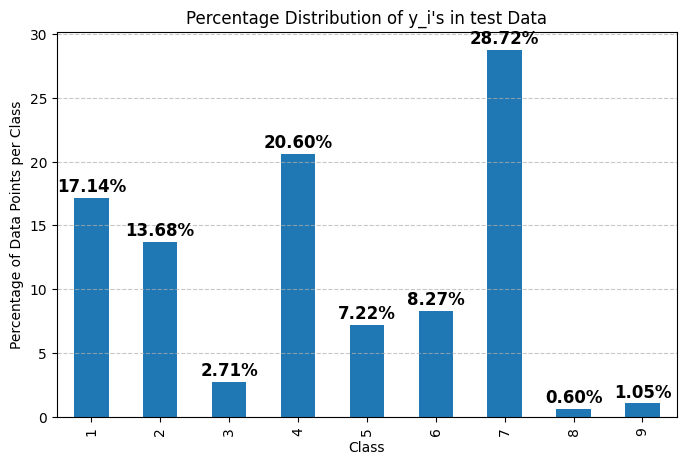

In [ ]:
datasets = [("train", train_class_distribution, train_df.shape[0]),
           ("cv", cv_class_distribution, cv_df.shape[0]),
           ("test", test_class_distribution, test_df.shape[0])]

for dataset_name, class_distribution, total_samples in datasets:
    plot_class_distribution(class_distribution, dataset_name)


### From the above plots, the Class label's distribution is same across train, cv and test.

In [ ]:
# Defining a function for Confusion Matrix.
def plot_confusion_matrix(test_y,predict_y):
  C= confusion_matrix(test_y, predict_y)

  A=(((C.T)/(C.sum(axis=1))).T)

  B=(C/C.sum(axis=0))

  labels=[1,2,3,4,5,6,7,8,9]

  print("_"*20,"Confusion Matrix", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

  print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

    # representing B in heatmap format
  print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()


## Categories of Genes and their distribution.

In [ ]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
print(unique_genes.head(10))

Number of Unique Genes : 229
Gene
BRCA1     159
TP53      102
EGFR       85
PTEN       79
BRCA2      79
KIT        61
BRAF       58
ERBB2      42
PIK3CA     39
TSC2       38
Name: count, dtype: int64


In [ ]:
print(unique_genes.shape[0],"different categories of genes are present in data and their distribution as follows")

229 different categories of genes are present in data and their distribution as follows


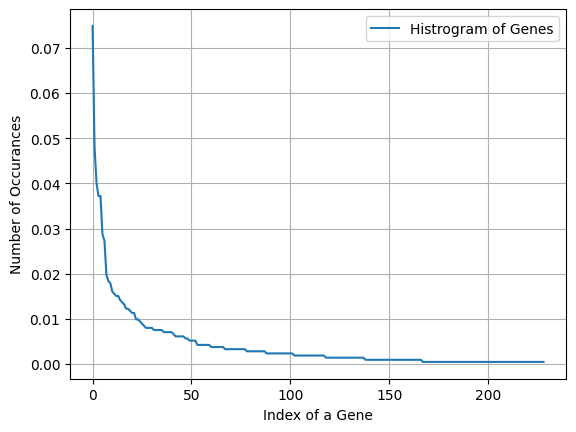

In [ ]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

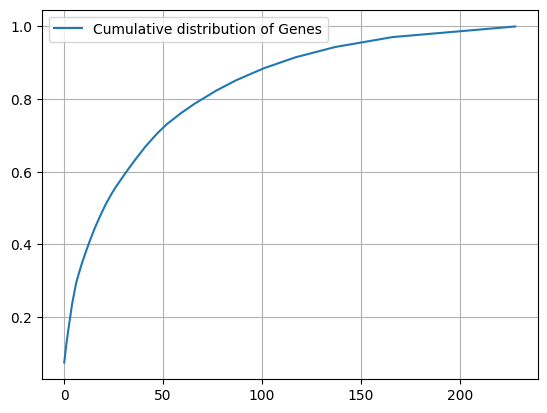

In [ ]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

# Featurizing Gene Feature using one hot encoding.

## One hot Encoding of Gene Feature.


In [ ]:
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [ ]:
train_df['Gene'].head()

325       ROS1
1226    PIK3CB
2393    PTPN11
1993    MAP2K1
1922       SMO
Name: Gene, dtype: object

In [ ]:
gene_vectorizer.get_feature_names_out()

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1a', 'arid1b', 'asxl1', 'asxl2', 'atm', 'atr',
       'atrx', 'aurka', 'b2m', 'bap1', 'bcl10', 'bcl2l11', 'bcor', 'braf',
       'brca1', 'brca2', 'brd4', 'brip1', 'btk', 'card11', 'carm1',
       'casp8', 'cbl', 'ccnd1', 'ccnd2', 'ccnd3', 'ccne1', 'cdh1',
       'cdk12', 'cdk4', 'cdk6', 'cdk8', 'cdkn1a', 'cdkn1b', 'cdkn2a',
       'cdkn2b', 'cebpa', 'chek2', 'cic', 'crebbp', 'ctcf', 'ctnnb1',
       'ddr2', 'dicer1', 'dnmt3a', 'dnmt3b', 'dusp4', 'egfr', 'eif1ax',
       'elf3', 'ep300', 'epas1', 'epcam', 'erbb2', 'erbb3', 'erbb4',
       'ercc2', 'ercc3', 'ercc4', 'erg', 'esr1', 'etv1', 'etv6', 'ewsr1',
       'ezh2', 'fanca', 'fancc', 'fat1', 'fbxw7', 'fgf3', 'fgf4', 'fgfr1',
       'fgfr2', 'fgfr3', 'fgfr4', 'flt1', 'flt3', 'foxa1', 'foxl2',
       'foxo1', 'gata3', 'gna11', 'gnaq', 'gnas', 'h3f3a', 'hist1h1c',
       'hla', 'hnf1a', 'hras', 'idh1', 'idh2', 'igf1r', 'ikbke', 'il7r',
     

In [ ]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 229)


How many data points in Test and CV datasets are covered by the 220 genes in train dataset?

In [ ]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)


Ans
1. In test data 640 out of 665 : 96.2406015037594
2. In cross validation data 515 out of  532 : 96.80451127819549


Variation is a categorical variable, so
how many categories are present?





In [ ]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1924
Variation
Truncating Mutations    56
Amplification           54
Deletion                45
Fusions                 19
G12V                     4
Q61R                     3
E17K                     3
Q61L                     3
G12A                     2
P34R                     2
Name: count, dtype: int64


In [ ]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1924 different categories of variations in the train data, and they are distibuted as follows


How to featurize this Variation feature ?

We are featurizing this variation feature using One hot encoding




In [ ]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [ ]:
print("train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature: (2124, 1960)


How many data points in Test and CV datasets are covered by the variations in train dataset?

In [ ]:
print(" How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

 How many data points are covered by total  1924  genes in test and cross validation data sets?
Ans
1. In test data 65 out of 665 : 9.774436090225564
2. In cross validation data 53 out of  532 : 9.962406015037594


# Univariate Analysis of Text Feature

## How many unique words present?

In [ ]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

Building a CountVectorizer with all the words that occured minimum 3 times in train data

In [ ]:
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features= text_vectorizer.get_feature_names_out()


train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1


text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 54110


Normalizing the features

In [ ]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)


test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])

test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)


cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [ ]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [ ]:
print(Counter(sorted_text_occur))

Counter({3: 5541, 4: 3814, 5: 3045, 6: 2620, 8: 2012, 7: 1795, 10: 1730, 9: 1608, 12: 1510, 11: 1407, 15: 892, 16: 839, 13: 792, 14: 753, 17: 695, 18: 689, 19: 624, 20: 618, 22: 563, 24: 552, 21: 454, 23: 409, 26: 393, 30: 385, 25: 383, 27: 363, 42: 353, 36: 329, 46: 328, 28: 322, 29: 311, 32: 308, 33: 270, 35: 249, 40: 247, 31: 236, 34: 235, 38: 217, 37: 213, 39: 210, 48: 197, 44: 192, 49: 182, 41: 181, 45: 178, 47: 170, 43: 170, 60: 169, 52: 158, 50: 150, 56: 148, 53: 144, 51: 138, 55: 136, 54: 134, 57: 133, 72: 125, 64: 117, 59: 112, 71: 110, 61: 110, 65: 109, 62: 106, 66: 105, 58: 105, 70: 99, 63: 99, 67: 98, 92: 96, 73: 90, 77: 87, 74: 86, 86: 85, 84: 85, 68: 84, 79: 82, 81: 81, 69: 80, 93: 77, 75: 77, 76: 74, 95: 73, 80: 71, 78: 71, 83: 70, 99: 69, 82: 68, 88: 67, 90: 65, 85: 64, 107: 63, 96: 63, 89: 63, 108: 59, 91: 59, 103: 58, 94: 58, 104: 57, 100: 56, 102: 55, 87: 53, 112: 47, 101: 47, 98: 47, 138: 46, 118: 46, 114: 46, 109: 45, 106: 45, 105: 45, 97: 45, 116: 44, 132: 43, 120

How many words of train data are present in test and CV data?

In [ ]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [ ]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.548 % of word of test data appeared in train data
97.89 % of word of Cross Validation appeared in train data


# Data Preparation

## Gene, Var, text One hot encoded

In [ ]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [ ]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56299)
(number of data points * number of features) in test data =  (665, 56299)
(number of data points * number of features) in cross validation data = (532, 56299)


### Vectorizing Text with TFIDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_tfidf = tfidf_vectorizer.fit_transform(train_df['TEXT'])

train_text_tfidf_features= tfidf_vectorizer.get_feature_names_out()

train_text_fea_counts = train_text_feature_tfidf.sum(axis=0).A1


text_fea_dict = dict(zip(list(train_text_tfidf_features),train_text_fea_counts))

print(f"TF-IDF transformation completed. Vocabulary size: {len(train_text_tfidf_features)}")



TF-IDF transformation completed. Vocabulary size: 54110


In [ ]:

cv_text_feature_tfidf = tfidf_vectorizer.transform(cv_df['TEXT'])

test_text_feature_tfidf = tfidf_vectorizer.transform(test_df['TEXT'])


train_text_feature_tfidf = normalize(train_text_feature_tfidf, axis=0)

cv_text_feature_tfidf = normalize(cv_text_feature_tfidf, axis =0)

test_text_feature_tfidf = normalize(test_text_feature_tfidf, axis =0)

In [ ]:
train_x_tfidf = hstack((train_gene_var_onehotCoding,train_text_feature_tfidf )).tocsr()
train_y = np.array(list(train_df['Class']))

cv_tfidf = hstack((cv_gene_var_onehotCoding,cv_text_feature_tfidf )).tocsr()
cv_y = np.array(list(cv_df['Class']))

test_tfidf = hstack((test_gene_var_onehotCoding,test_text_feature_tfidf)).tocsr()
test_y = np.array(list(test_df['Class']))

In [ ]:
print("Tfidf features :")
print("(number of data points * number of features) in train data = ", train_x_tfidf.shape)
print("(number of data points * number of features) in cross validation data = ", cv_tfidf.shape)
print("(number of data points * number of features) in test data =", test_tfidf.shape)

Tfidf features :
(number of data points * number of features) in train data =  (2124, 56299)
(number of data points * number of features) in cross validation data =  (532, 56299)
(number of data points * number of features) in test data = (665, 56299)


### Vectorizing text with max features 1000.

In [ ]:

tfidf_vectorizer_maxft = TfidfVectorizer(max_features = 1000, min_df =3)
train_text_feature_tfidf_maxft = tfidf_vectorizer_maxft.fit_transform(train_df['TEXT'])
train_text_features_tfidf_max_features = tfidf_vectorizer_maxft.get_feature_names_out()
train_text_fea_max_ft_counts = train_text_feature_tfidf_maxft.sum(axis=0).A1
text_fea_dict_max_ft = dict(zip(list(train_text_features_tfidf_max_features), train_text_fea_max_ft_counts))
print("Total number of unique words in train data :", len(train_text_features_tfidf_max_features))


Total number of unique words in train data : 1000


In [ ]:
cv_text_feature_tfidf_maxft = tfidf_vectorizer_maxft.transform(cv_df['TEXT'])
test_text_feature_tfidf_maxft = tfidf_vectorizer_maxft.transform(test_df['TEXT'])
train_text_feature_tfidf_maxft = normalize(train_text_feature_tfidf_maxft, axis =0)
cv_text_feature_tfidf_maxft = normalize(cv_text_feature_tfidf_maxft, axis =0)
test_text_feature_tfidf_maxft = normalize(test_text_feature_tfidf_maxft, axis =0)

In [ ]:
train_x_tfidf_maxft = hstack((train_gene_var_onehotCoding,train_text_feature_tfidf_maxft )).tocsr()
train_y = np.array(list(train_df['Class']))

cv_tfidf_maxft = hstack((cv_gene_var_onehotCoding,cv_text_feature_tfidf_maxft)).tocsr()
cv_y = np.array(list(cv_df['Class']))

test_tfidf_maxft = hstack((test_gene_var_onehotCoding,test_text_feature_tfidf_maxft)).tocsr()
test_y = np.array(list(test_df['Class']))

In [ ]:
print("Tfidf Max_1000 features :")
print("(number of data points * number of features) in train data = ", train_x_tfidf_maxft.shape)
print("(number of data points * number of features) in cross validation data = ", cv_tfidf_maxft.shape)
print("(number of data points * number of features) in test data =", test_tfidf_maxft.shape)

Tfidf Max_1000 features :
(number of data points * number of features) in train data =  (2124, 3189)
(number of data points * number of features) in cross validation data =  (532, 3189)
(number of data points * number of features) in test data = (665, 3189)


# Machine Learning Models

In [ ]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we will provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [ ]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

# Logistic Regresssion

## With class balancing

# Hyper parameter tuning

for alpha = 1e-06
Log Loss : 1.2994832815495811
for alpha = 1e-05
Log Loss : 1.2513880162958433
for alpha = 0.0001
Log Loss : 1.08193196298675
for alpha = 0.001
Log Loss : 1.0346205252846858
for alpha = 0.01
Log Loss : 1.0938827959236073
for alpha = 0.1
Log Loss : 1.443943090647424
for alpha = 1
Log Loss : 1.6995414945170304
for alpha = 10
Log Loss : 1.7301603897013123
for alpha = 100
Log Loss : 1.7333190609949356


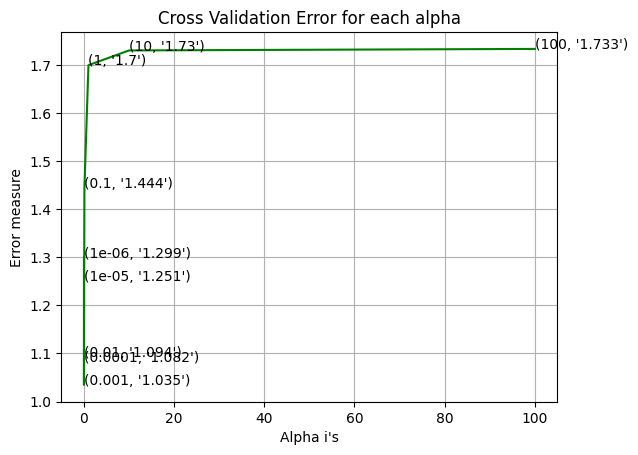

For Train data with alpha=3, Log Loss: 0.5110063491999025
For Cross Validation data with alpha=3, Log Loss: 1.0346205252846858
For Test data with alpha=3, Log Loss: 1.0990760564699484


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)
    print("Log Loss :",log_loss_value)



fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_onehotCoding, train_y),
                           ("Cross Validation", cv_x_onehotCoding, cv_y),
                           ("Test", test_x_onehotCoding, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0990760564699484
Number of mis-classified points : 0.37142857142857144
____________________ Confusion Matrix --------------------


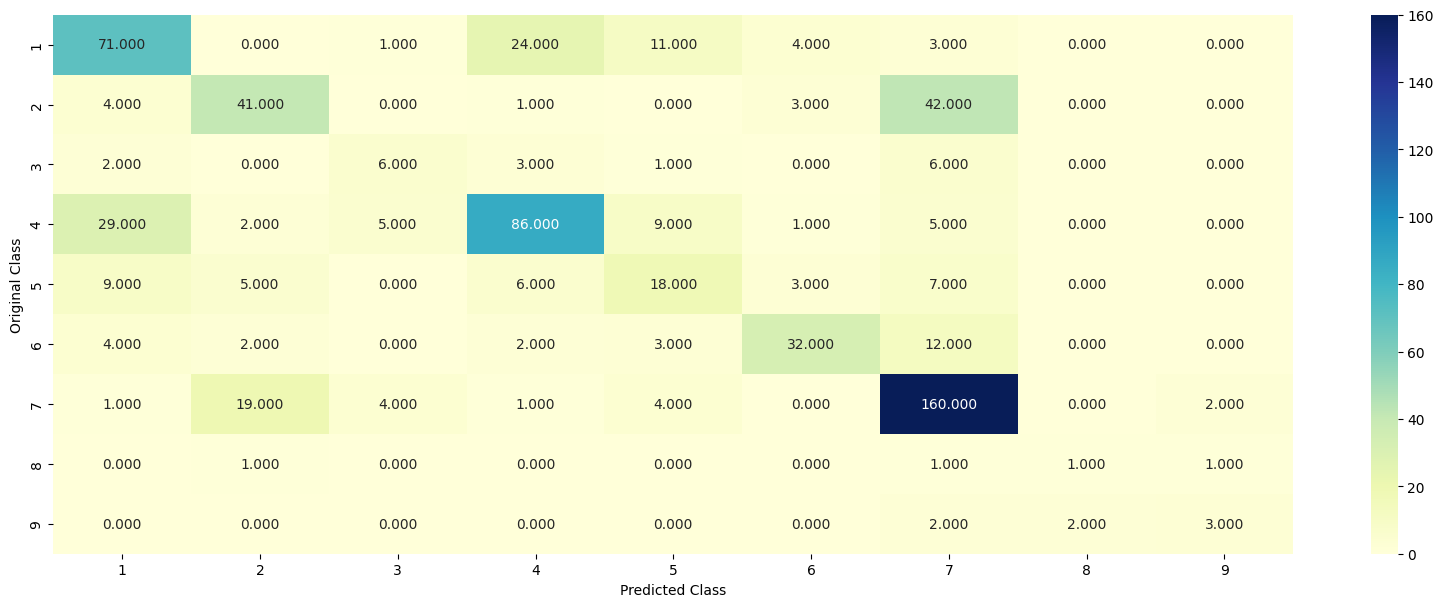

-------------------- Precision matrix (Columm Sum=1) --------------------


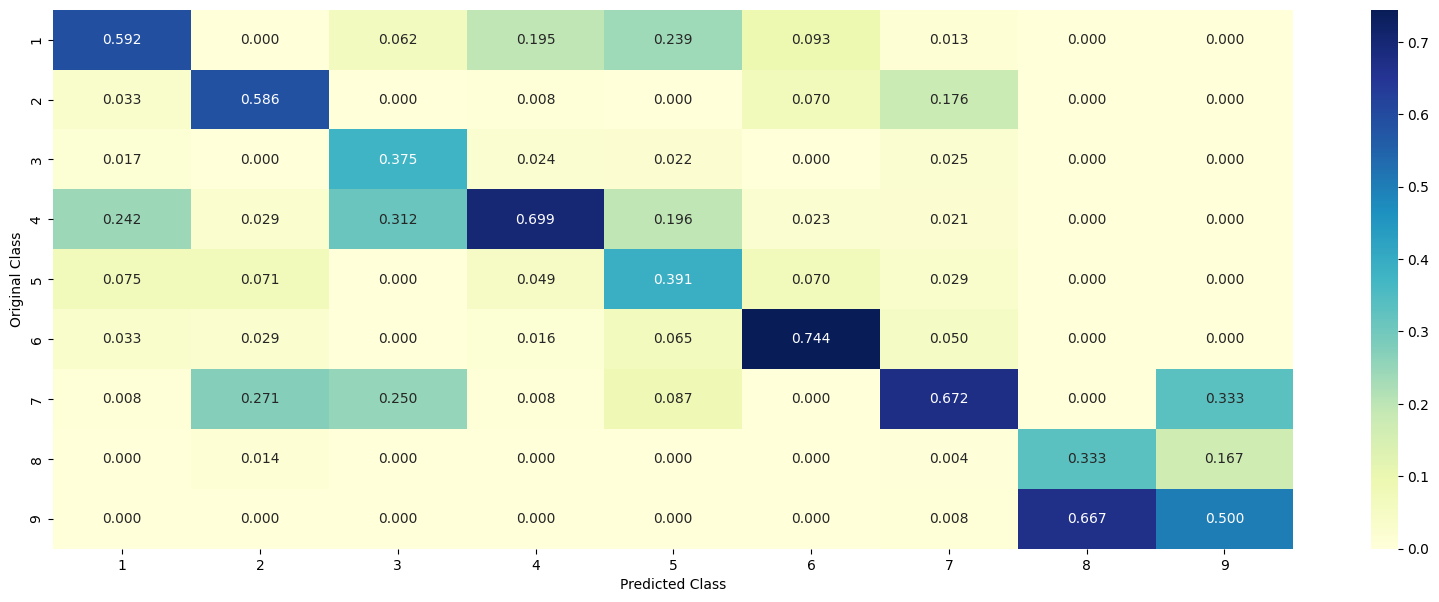

-------------------- Recall matrix (Row sum=1) --------------------


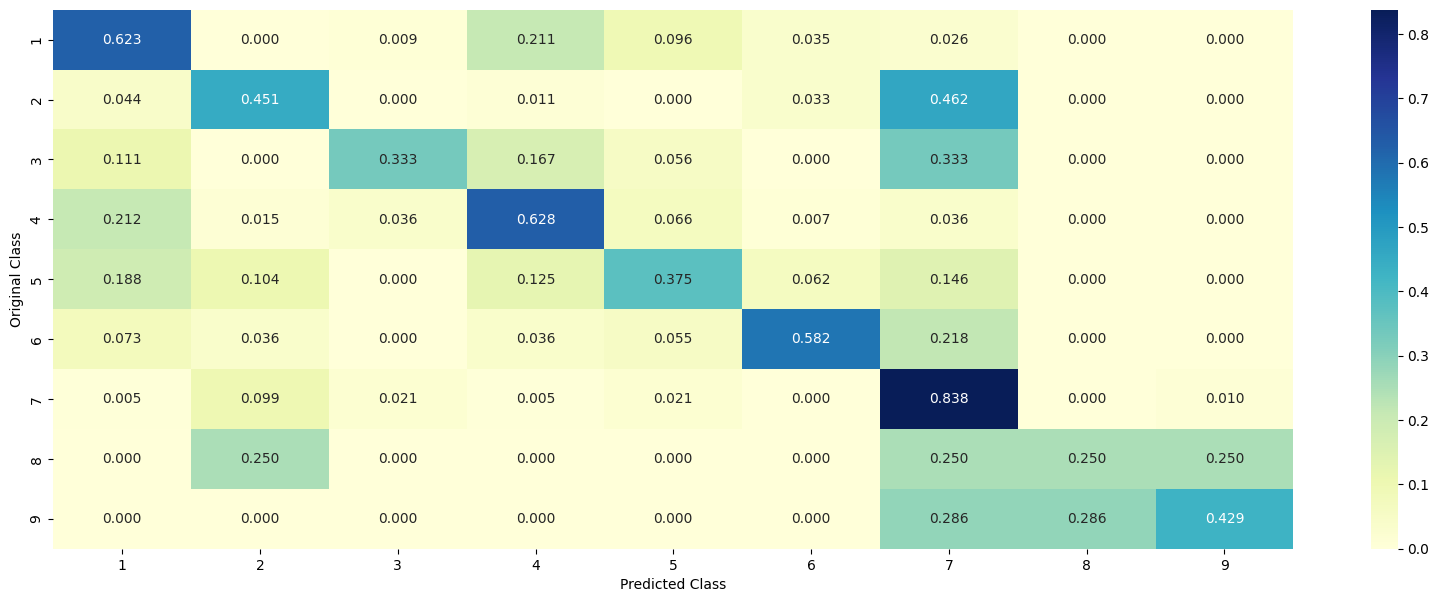

In [ ]:
# Testing the model with best hyper paramters

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, test_x_onehotCoding, test_y, clf)

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 10
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)


Predicted Class : 3
Predicted Class Probabilities: [[0.0222 0.0313 0.5068 0.0376 0.2657 0.0098 0.1158 0.0047 0.006 ]]
Actual Class : 1
--------------------------------------------------


In [ ]:
# Incorrectly Classified point

test_point_index = 22
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)


Predicted Class : 7
Predicted Class Probabilities: [[1.100e-03 1.700e-03 5.000e-04 2.000e-03 2.100e-03 1.100e-03 9.894e-01
  1.300e-03 8.000e-04]]
Actual Class : 7
--------------------------------------------------


# With TFIDF Features

For alpha = 1e-06
Log Loss: 1.2343192423599039
For alpha = 1e-05
Log Loss: 1.2044169600063765
For alpha = 0.0001
Log Loss: 1.007455731320549
For alpha = 0.001
Log Loss: 0.995629357459126
For alpha = 0.01
Log Loss: 1.0497983799187525
For alpha = 0.1
Log Loss: 1.1997682016304054
For alpha = 1
Log Loss: 1.4777459833218733
For alpha = 10
Log Loss: 1.5235602664050039
For alpha = 100
Log Loss: 1.528368605838747


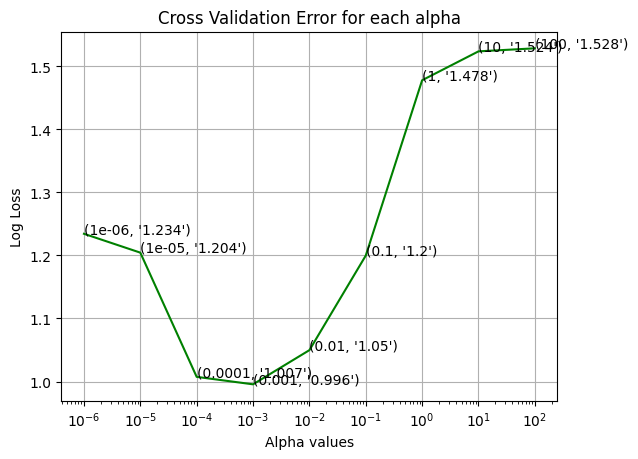

Best Alpha: 0.001
For Train data with alpha=0.001, Log Loss: 0.4878186509781217
For Cross Validation data with alpha=0.001, Log Loss: 0.995629357459126
For Test data with alpha=0.001, Log Loss: 1.0810807478162763


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Log Loss
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf)

    # Clip probabilities to prevent log(0) errors
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)

    # Compute Log Loss
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

#Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]


print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf, train_y),
                           ("Cross Validation", cv_tfidf, cv_y),
                           ("Test", test_tfidf, y_test)]:

    predict_y = sig_clf.predict_proba(X)
    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)  # Avoid log(0) error

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0810807478162763
Number of mis-classified points : 0.3804511278195489
____________________ Confusion Matrix --------------------


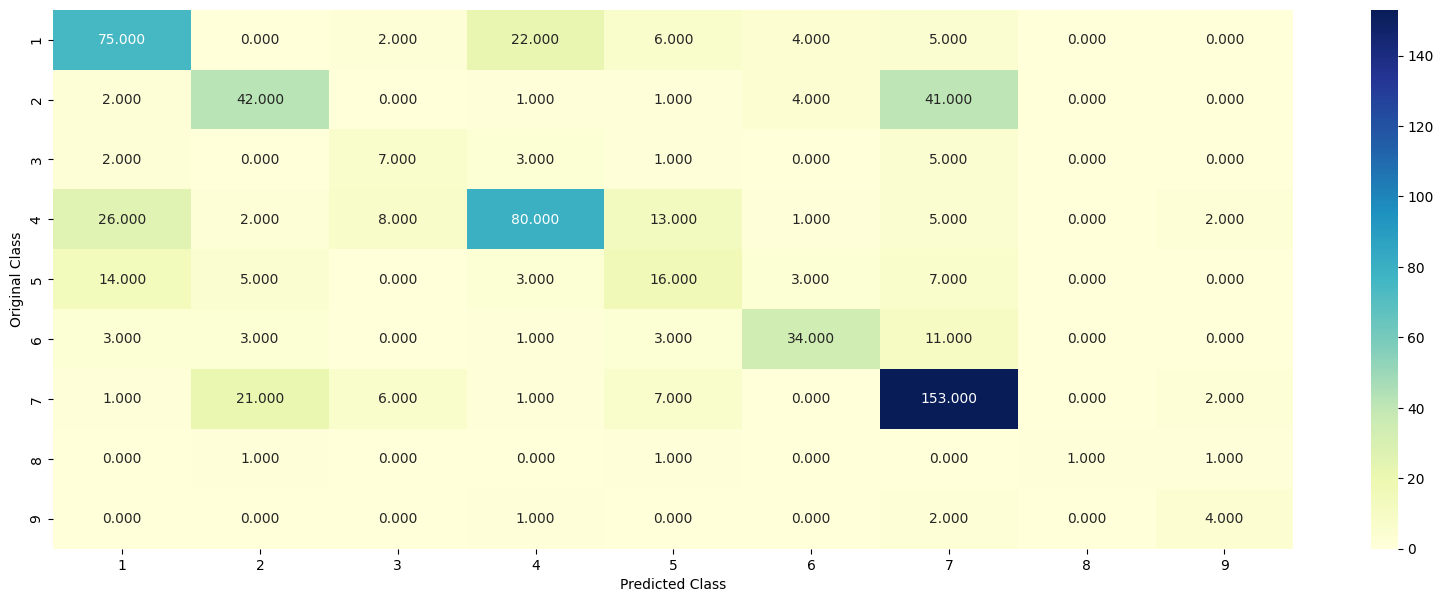

-------------------- Precision matrix (Columm Sum=1) --------------------


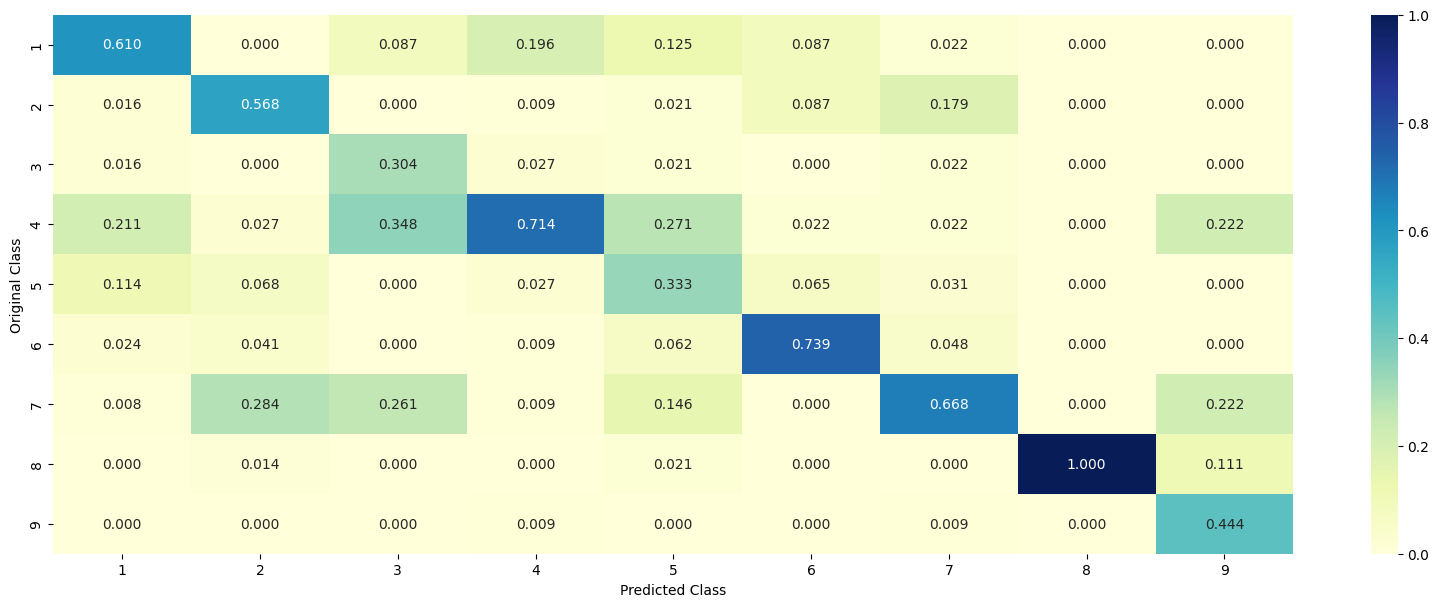

-------------------- Recall matrix (Row sum=1) --------------------


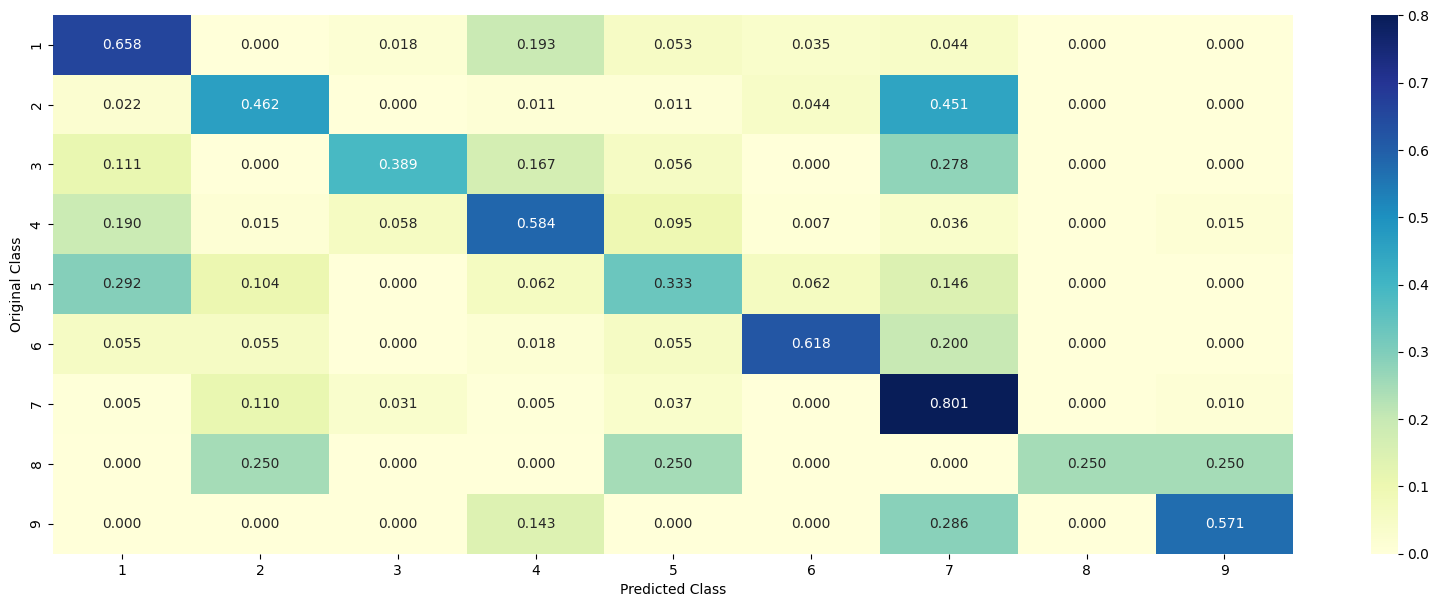

In [ ]:
clf = SGDClassifier(class_weight='balanced',alpha = alpha[best_alpha_idx], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_tfidf, test_y, clf)

### TFIDF with top 1000 features


For alpha = 1e-06
Log Loss: 1.1119294775204573
For alpha = 1e-05
Log Loss: 0.9998865016240868
For alpha = 0.0001
Log Loss: 0.9376562860836578
For alpha = 0.001
Log Loss: 0.9840597898421694
For alpha = 0.01
Log Loss: 1.1610571246779071
For alpha = 0.1
Log Loss: 1.5707296069410206
For alpha = 1
Log Loss: 1.7342052124429224
For alpha = 10
Log Loss: 1.7530860073083574
For alpha = 100
Log Loss: 1.7552692170357553


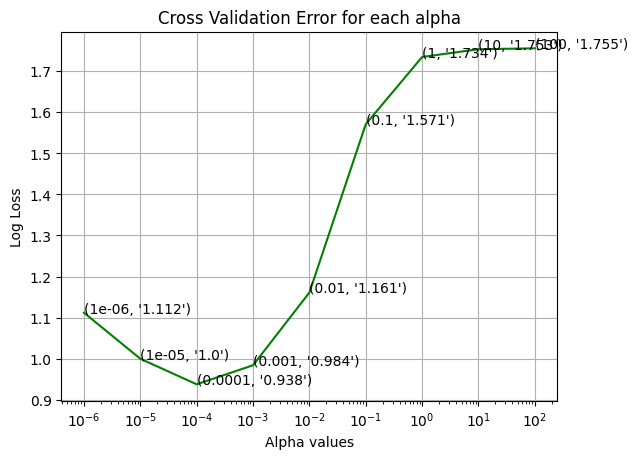

Best Alpha: 0.0001
For Train data with alpha=0.0001, Log Loss: 0.40370510822085953
For Cross Validation data with alpha=0.0001, Log Loss: 0.9376562860836578
For Test data with alpha=0.0001, Log Loss: 1.0229972777257696


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Log Loss
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf_maxft, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf_maxft, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_maxft)

    # Clip probabilities to prevent log(0) errors
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)

    # Compute Log Loss
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

#Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]


print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf_maxft, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_maxft, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf_maxft, train_y),
                           ("Cross Validation", cv_tfidf_maxft, cv_y),
                           ("Test", test_tfidf_maxft, y_test)]:

    predict_y = sig_clf.predict_proba(X)
    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)  # Avoid log(0) error

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0229972777257696
Number of mis-classified points : 0.34135338345864663
____________________ Confusion Matrix --------------------


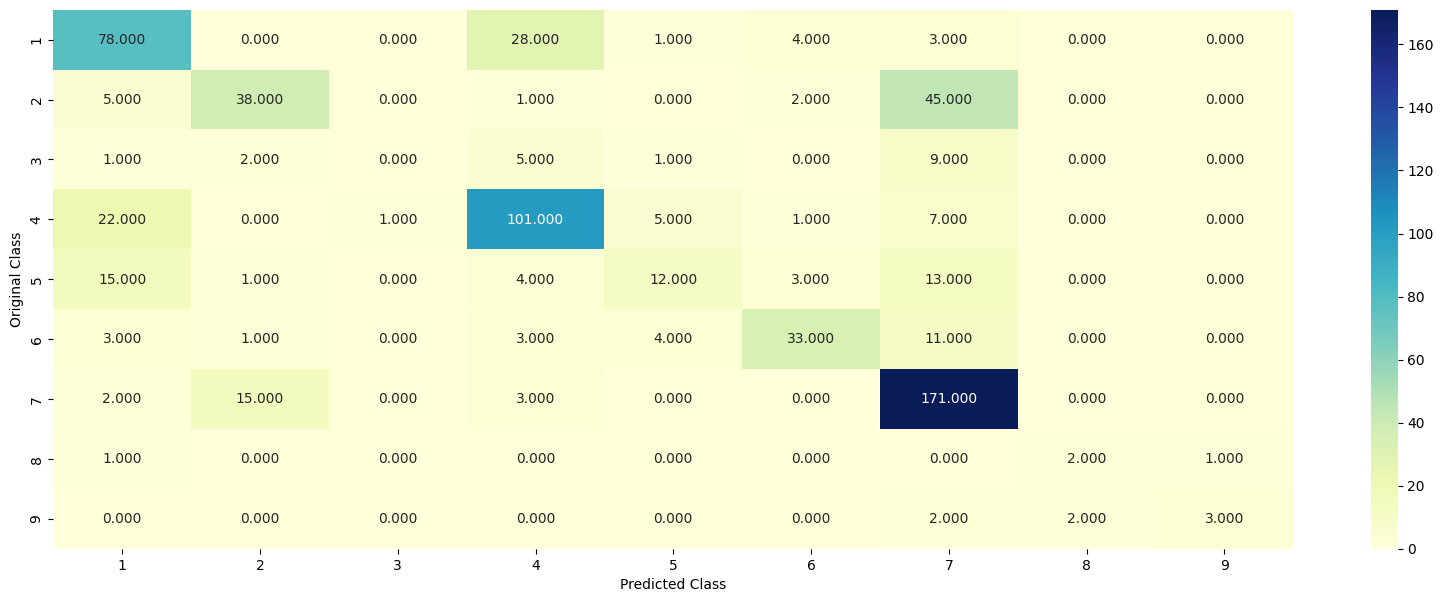

-------------------- Precision matrix (Columm Sum=1) --------------------


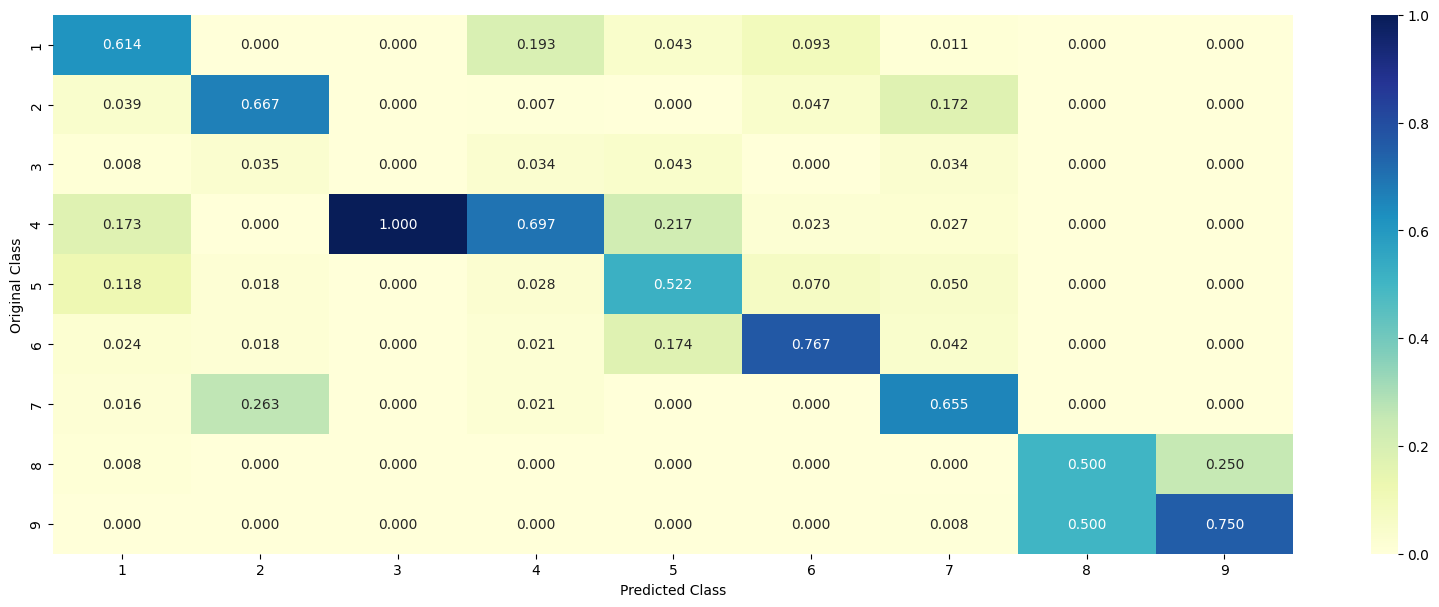

-------------------- Recall matrix (Row sum=1) --------------------


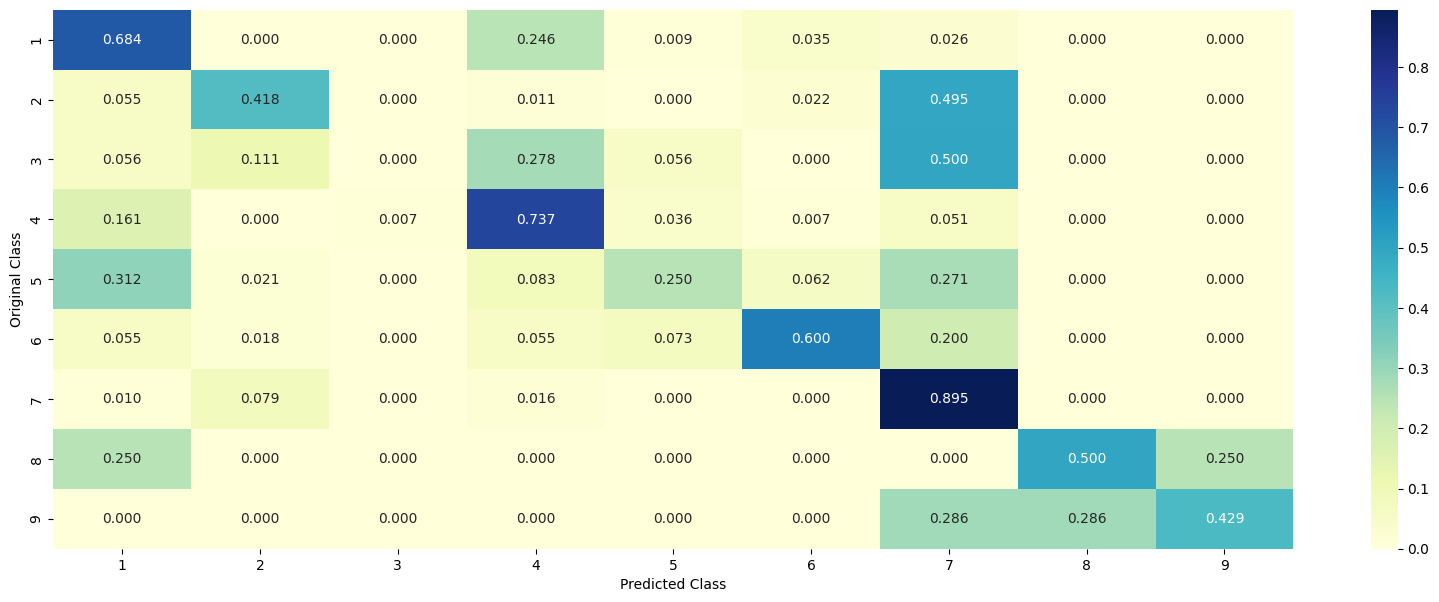

In [ ]:
clf = SGDClassifier(class_weight='balanced',alpha = alpha[best_alpha_idx], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf_maxft, train_y, test_tfidf_maxft, test_y, clf)

## Without Class balancing

for alpha = 1e-06
Log Loss : 1.31369888926585
for alpha = 1e-05
Log Loss : 1.2636328255131668
for alpha = 0.0001
Log Loss : 1.1103908388413055
for alpha = 0.001
Log Loss : 1.058042593888396
for alpha = 0.01
Log Loss : 1.145585566671015
for alpha = 0.1
Log Loss : 1.3240367030880462
for alpha = 1
Log Loss : 1.5725954066398284
for alpha = 10
Log Loss : 1.6147706042175203
for alpha = 100
Log Loss : 1.6195216987036731


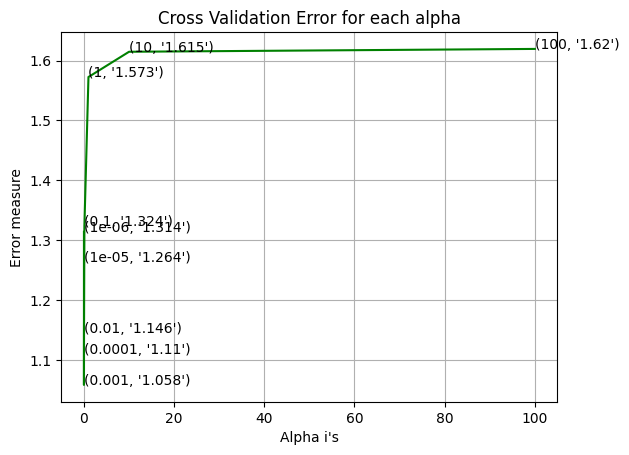

For Train data with alpha=3, Log Loss: 0.5152497867744013
For Cross Validation data with alpha=3, Log Loss: 1.058042593888396
For Test data with alpha=3, Log Loss: 1.1145906992178167


In [ ]:
# Hyper parameter tuning

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)
    print("Log Loss :",log_loss_value)



fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier( alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_onehotCoding, train_y),
                           ("Cross Validation", cv_x_onehotCoding, cv_y),
                           ("Test", test_x_onehotCoding, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")


Log loss : 1.1529314728128341
Number of mis-classified points : 0.362406015037594
____________________ Confusion Matrix --------------------


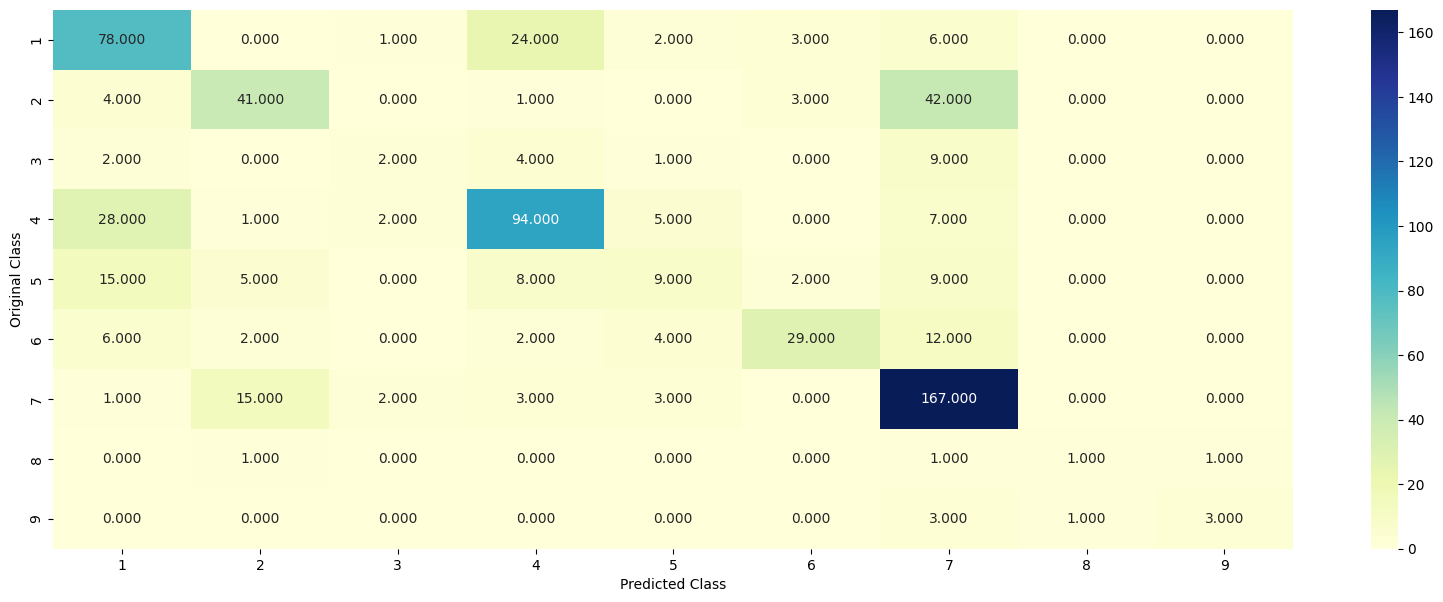

-------------------- Precision matrix (Columm Sum=1) --------------------


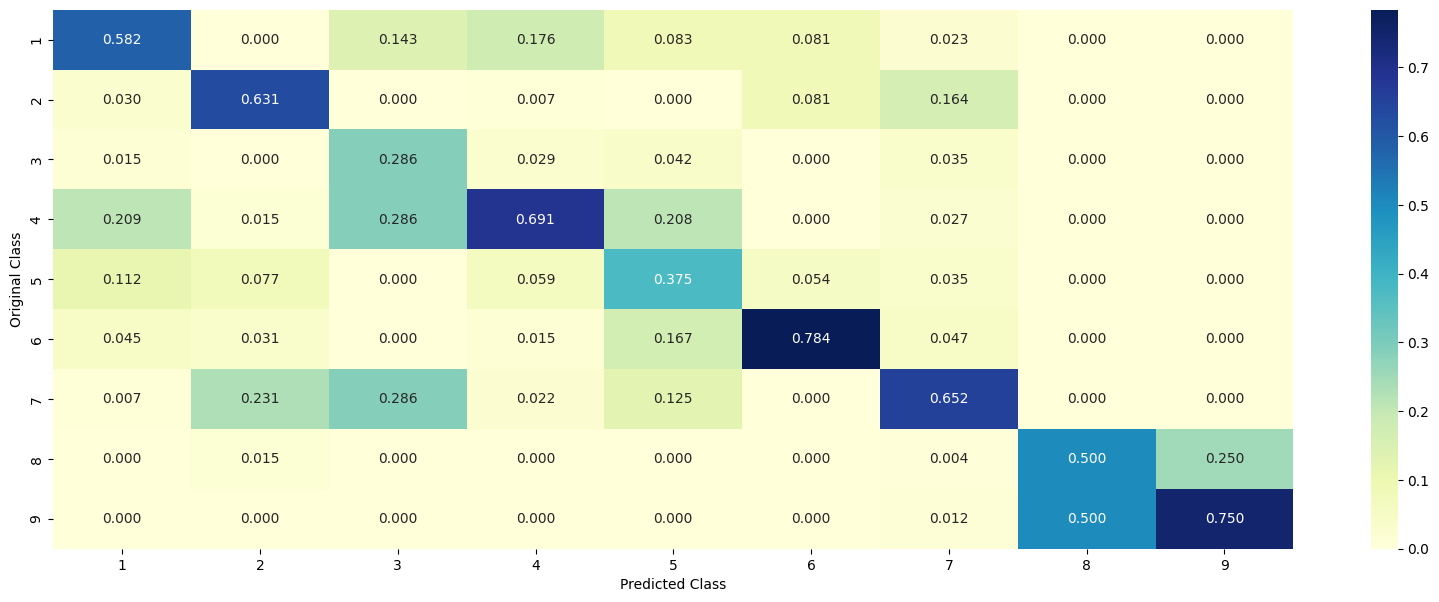

-------------------- Recall matrix (Row sum=1) --------------------


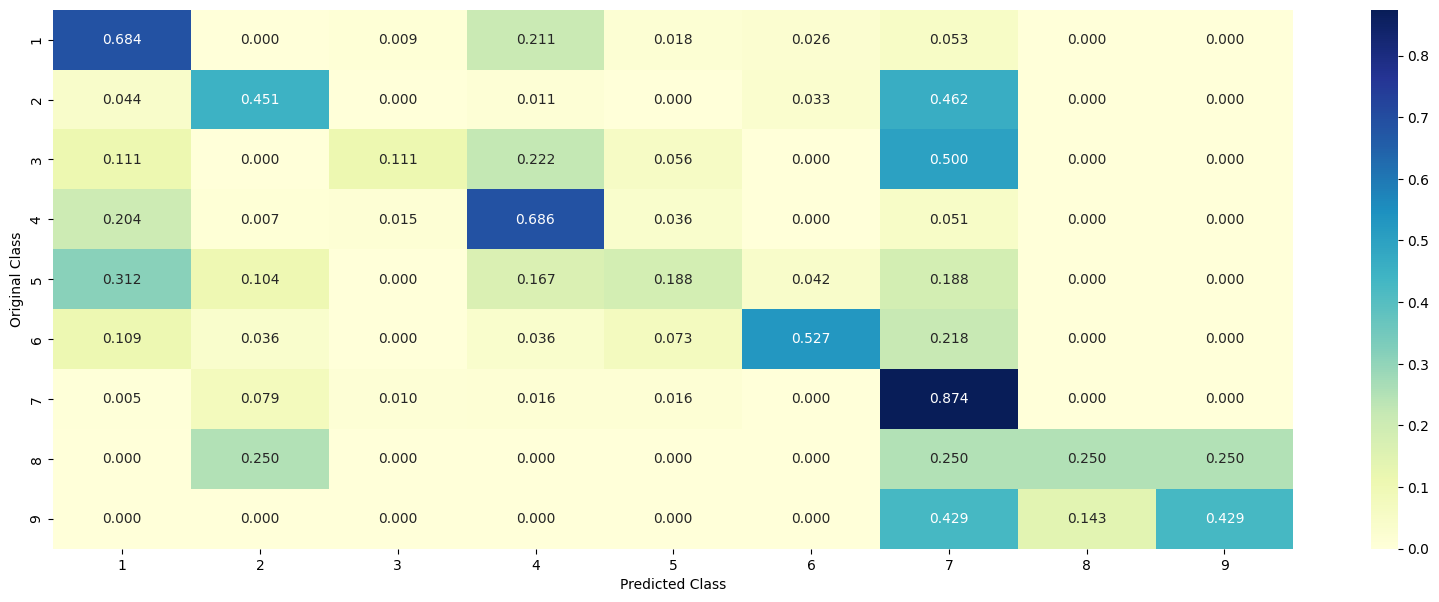

In [ ]:
# Testing the model with  best hyper parameters

clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, test_x_onehotCoding, test_y, clf)

In [ ]:

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 10
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]



Predicted Class : 3
Predicted Class Probabilities: [[0.0256 0.0362 0.4734 0.0401 0.2606 0.0117 0.1425 0.0071 0.0029]]
Actual Class : 1


In [ ]:
test_point_index = 8
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]



Predicted Class : 5
Predicted Class Probabilities: [[0.006  0.0129 0.0035 0.0078 0.5725 0.3823 0.0093 0.0043 0.0014]]
Actual Class : 6


### Tfidf text features

For alpha = 1e-06
Log Loss: 1.2381604247956404
For alpha = 1e-05
Log Loss: 1.2072093300045559
For alpha = 0.0001
Log Loss: 1.0496186663147844
For alpha = 0.001
Log Loss: 1.0110914467610723
For alpha = 0.01
Log Loss: 1.0675926950815997
For alpha = 0.1
Log Loss: 1.2275227226755379
For alpha = 1
Log Loss: 1.490937291240954
For alpha = 10
Log Loss: 1.5421016315462541
For alpha = 100
Log Loss: 1.547556713110392


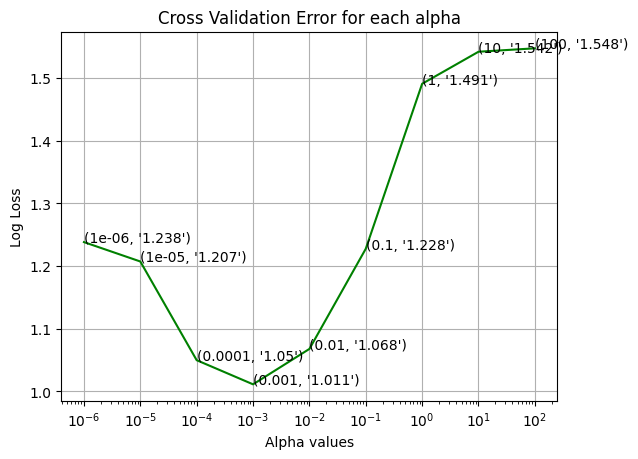

Best Alpha: 0.001
For Train data with alpha=0.001, Log Loss: 0.4839735492680645
For Cross Validation data with alpha=0.001, Log Loss: 1.0110914467610723
For Test data with alpha=0.001, Log Loss: 1.0790316611668835


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Log Loss
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf)

    # Clip probabilities to prevent log(0) errors
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)

    # Compute Log Loss
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

#Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]


print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier( alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf, train_y),
                           ("Cross Validation", cv_tfidf, cv_y),
                           ("Test", test_tfidf, y_test)]:

    predict_y = sig_clf.predict_proba(X)
    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)  # Avoid log(0) error

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0110914467610723
Number of mis-classified points : 0.32894736842105265
____________________ Confusion Matrix --------------------


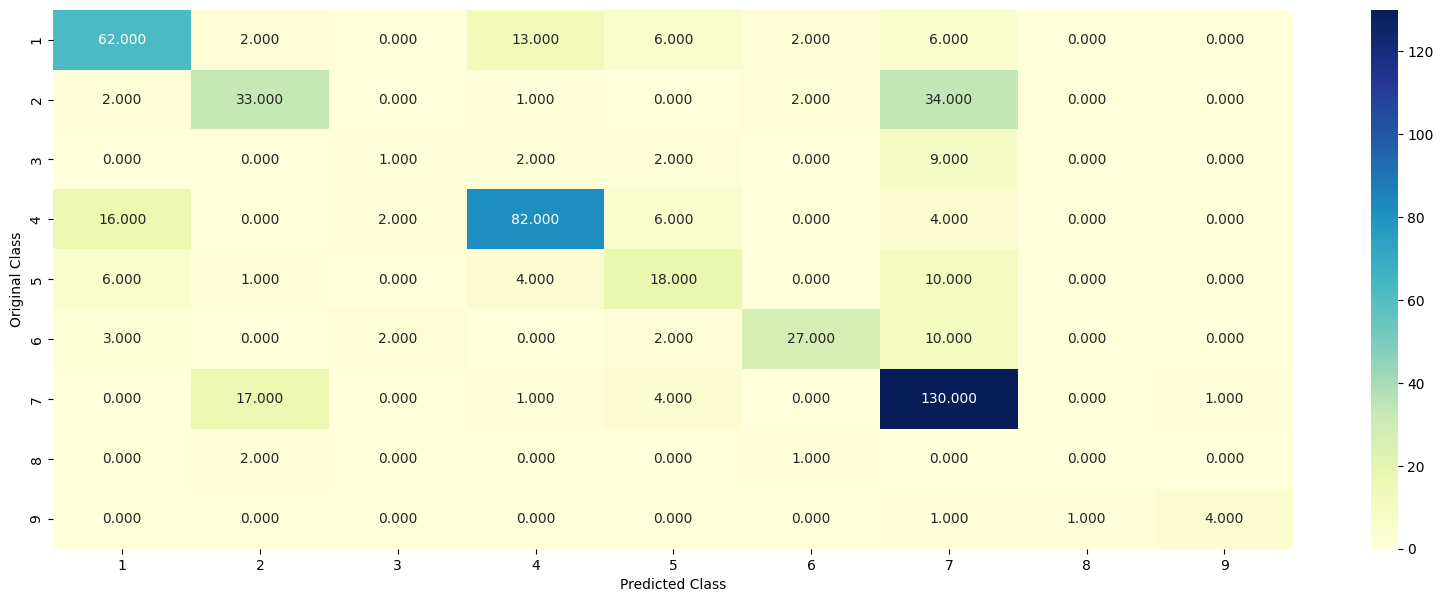

-------------------- Precision matrix (Columm Sum=1) --------------------


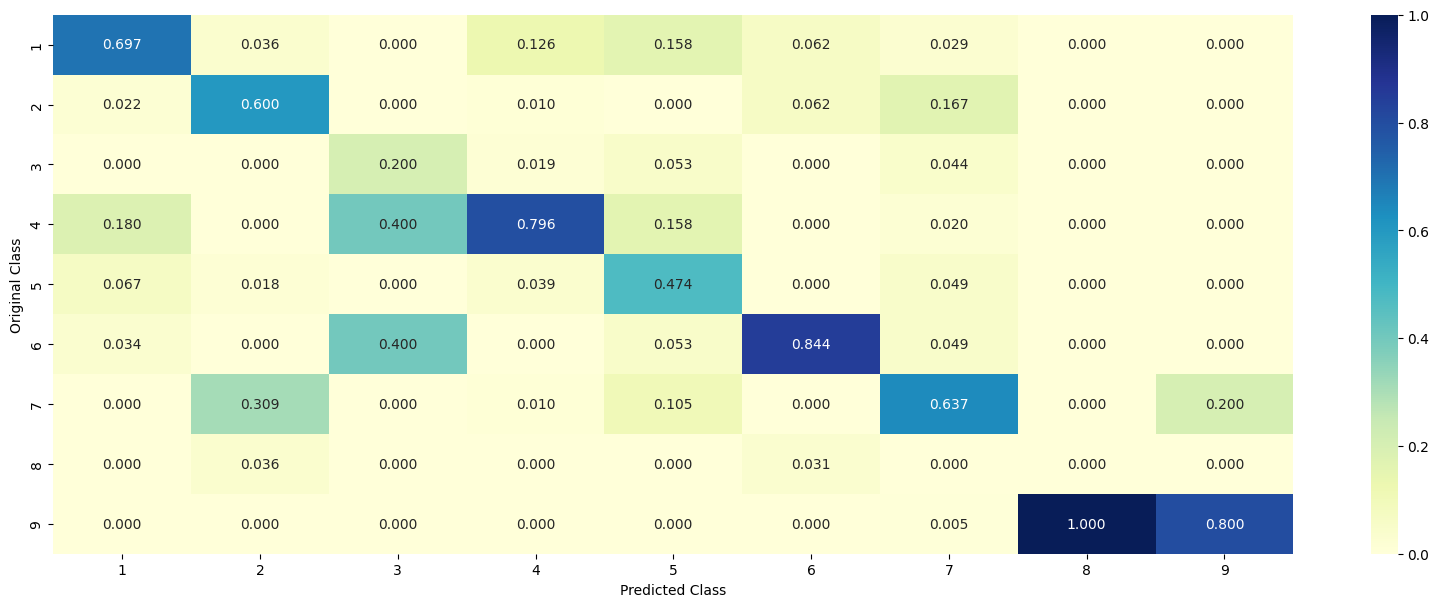

-------------------- Recall matrix (Row sum=1) --------------------


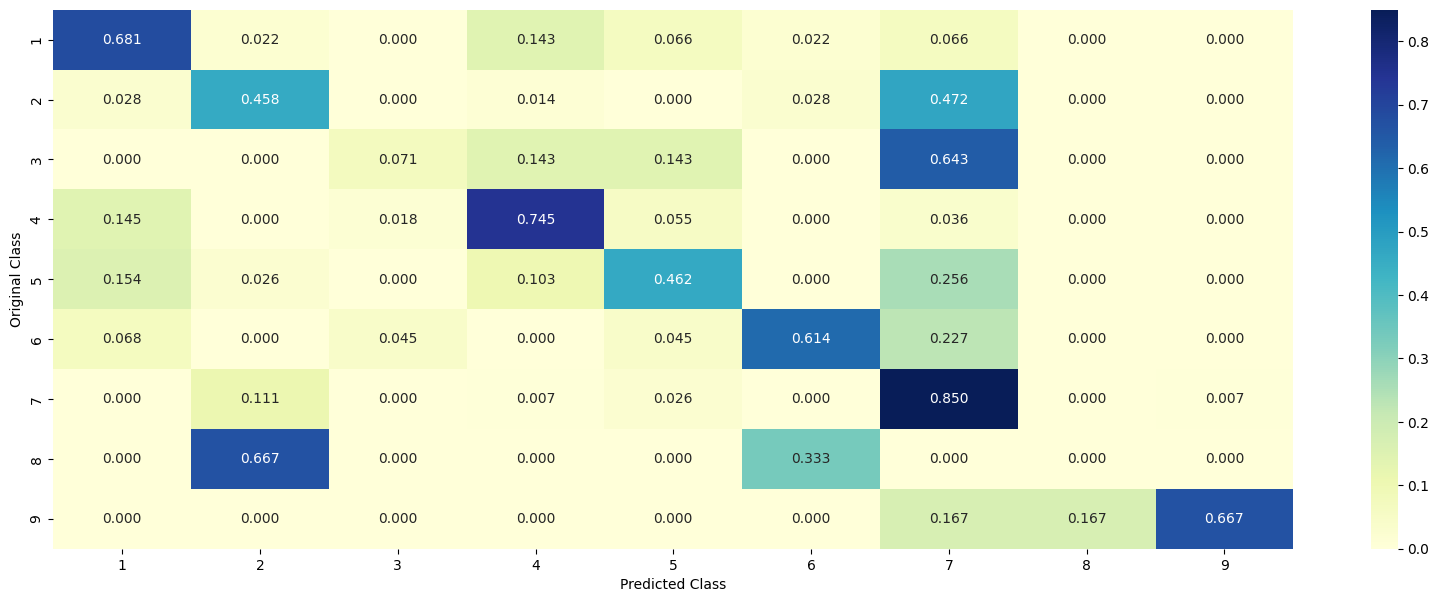

In [ ]:
clf = SGDClassifier(alpha = alpha[best_alpha_idx], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_tfidf, cv_y, clf)

### TFIDF with top 1000 features

For alpha = 1e-06
Log Loss: 1.1242010272095901
For alpha = 1e-05
Log Loss: 1.0248225791216934
For alpha = 0.0001
Log Loss: 0.9601284616069383
For alpha = 0.001
Log Loss: 1.0698837390686935
For alpha = 0.01
Log Loss: 1.436414083681663
For alpha = 0.1
Log Loss: 1.7651226040737023
For alpha = 1
Log Loss: 1.8283322317171558
For alpha = 10
Log Loss: 1.8361712827473626
For alpha = 100
Log Loss: 1.8371449025183773


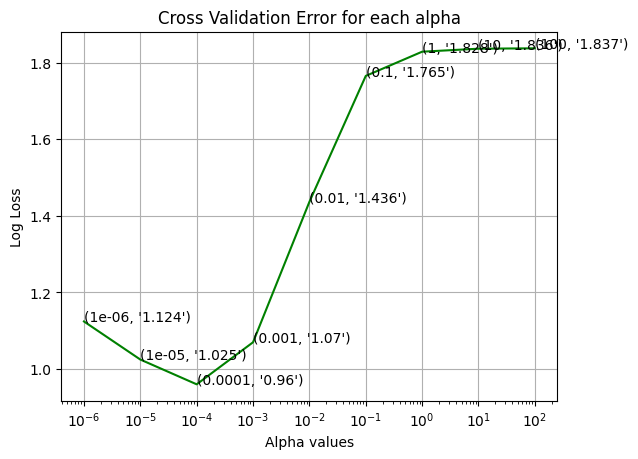

Best Alpha: 0.0001
For Train data with alpha=0.0001, Log Loss: 0.3928620943372092
For Cross Validation data with alpha=0.0001, Log Loss: 0.9601284616069383
For Test data with alpha=0.0001, Log Loss: 1.0425888401084675


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Log Loss
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf_maxft, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf_maxft, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_maxft)

    # Clip probabilities to prevent log(0) errors
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)

    # Compute Log Loss
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

#Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]


print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier( alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf_maxft, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_maxft, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf_maxft, train_y),
                           ("Cross Validation", cv_tfidf_maxft, cv_y),
                           ("Test", test_tfidf_maxft, y_test)]:

    predict_y = sig_clf.predict_proba(X)
    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)  # Avoid log(0) error

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0425888401084675
Number of mis-classified points : 0.3368421052631579
____________________ Confusion Matrix --------------------


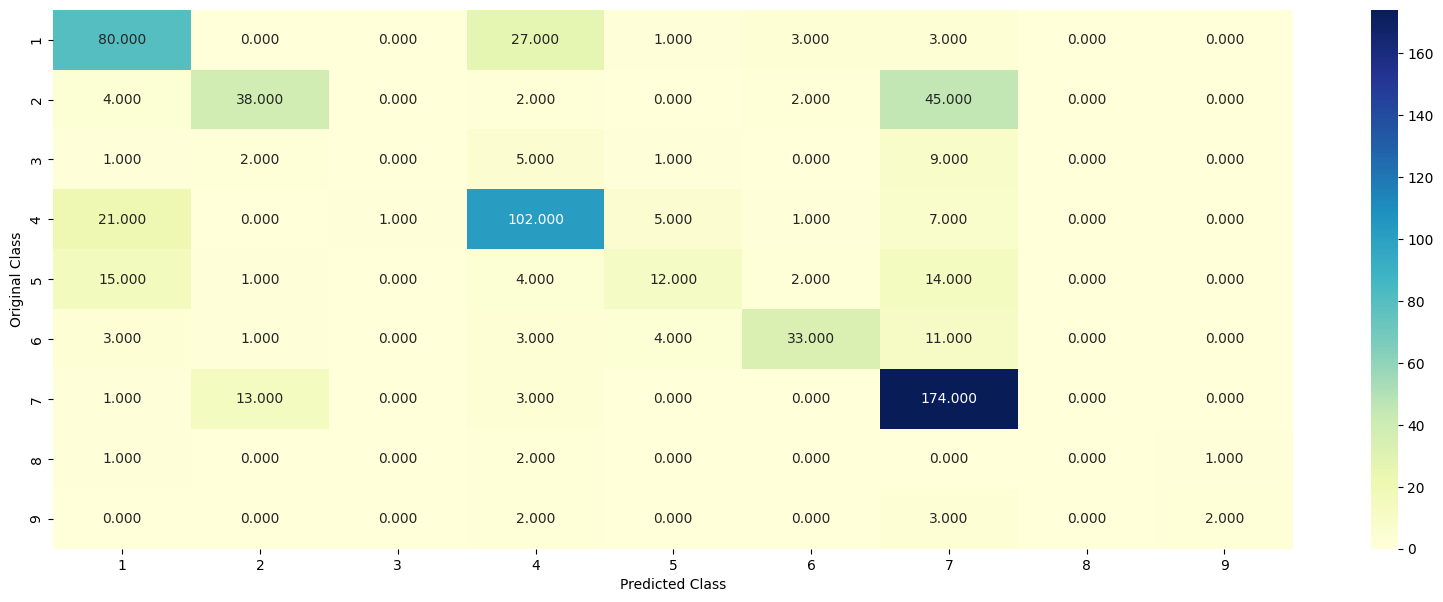

-------------------- Precision matrix (Columm Sum=1) --------------------


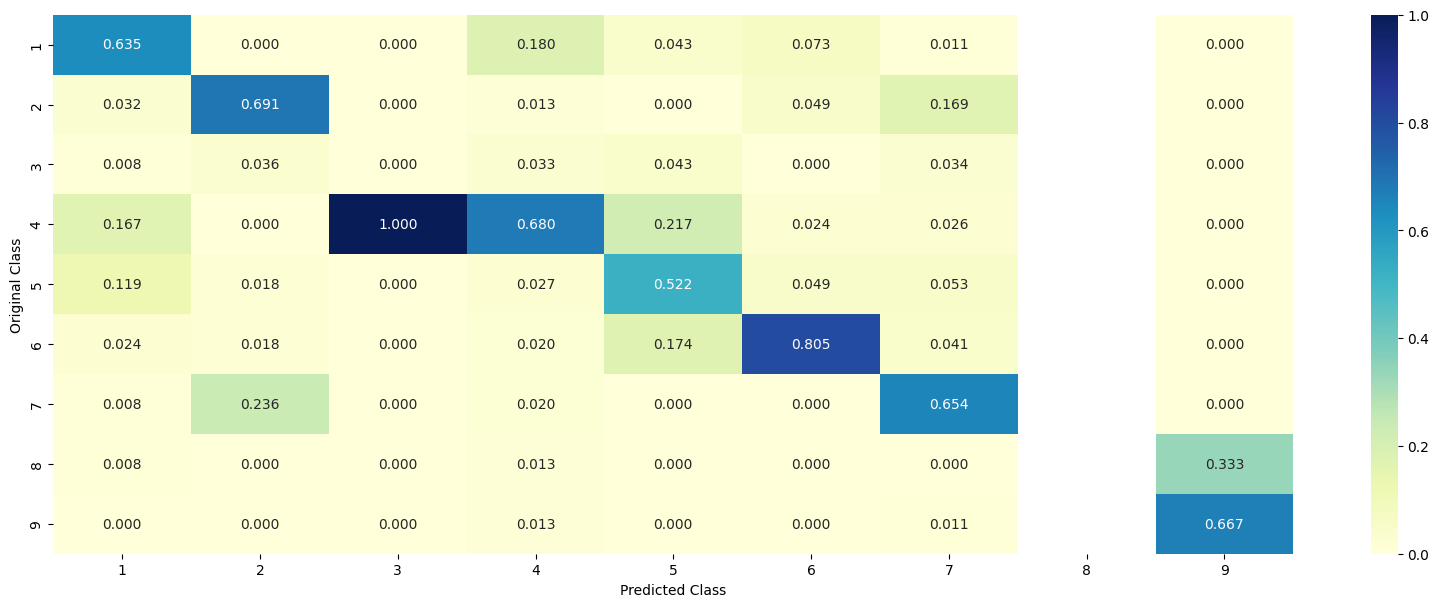

-------------------- Recall matrix (Row sum=1) --------------------


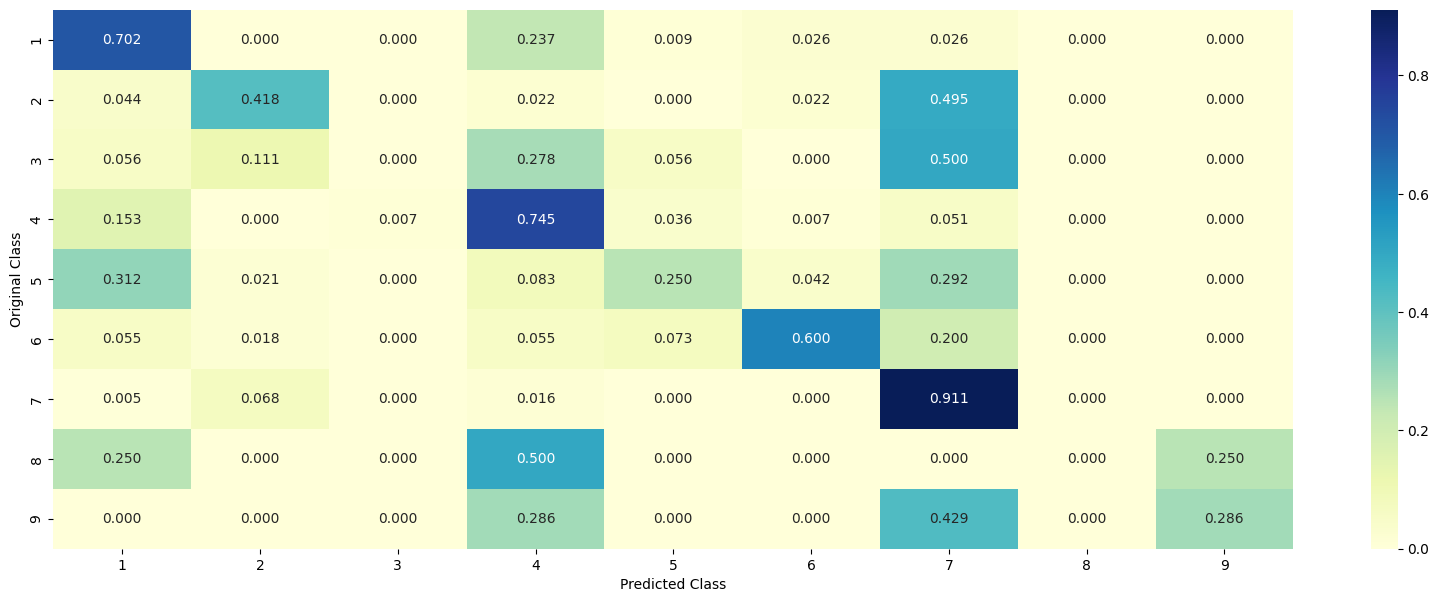

In [ ]:
clf = SGDClassifier(alpha = alpha[best_alpha_idx], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf_maxft, train_y, test_tfidf_maxft, test_y, clf)

# Support Vector Machines

For alpha = 1e-05
Log Loss: 1.2822385957773674
For alpha = 0.0001
Log Loss: 1.195367139181032
For alpha = 0.001
Log Loss: 1.1041484012591787
For alpha = 0.01
Log Loss: 1.0920782217276923
For alpha = 0.1
Log Loss: 1.361322121548567
For alpha = 1
Log Loss: 1.7156317600152156
For alpha = 10
Log Loss: 1.733802087105277
For alpha = 100
Log Loss: 1.7338551902067838


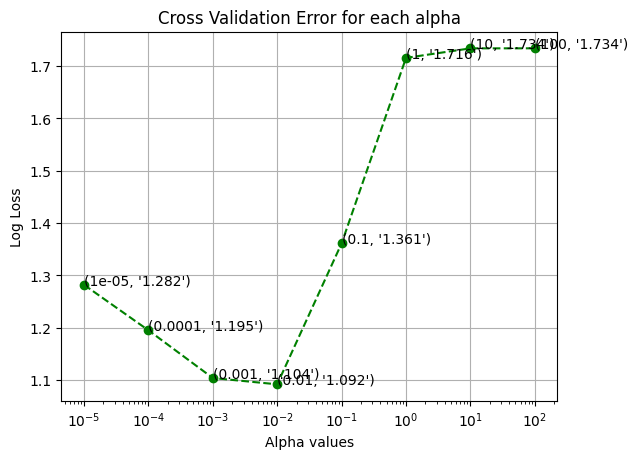

Best Alpha: 0.01
For Train data with alpha=0.01, Log Loss: 0.7881007307689514
For Cross Validation data with alpha=0.01, Log Loss: 1.1893792272718553
For Test data with alpha=0.01, Log Loss: 1.3131786281520574


In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Hinge Loss (Linear SVM)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)


    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)


    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g', marker='o', linestyle='dashed')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

# Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]

print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_onehotCoding, train_y),
                           ("Cross Validation", cv_x_onehotCoding, cv_y),
                           ("Test", test_x_onehotCoding, y_test)]:

    predict_y = sig_clf.predict_proba(X)


    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0920782217276923
Number of mis-classified points : 0.34774436090225563
____________________ Confusion Matrix --------------------


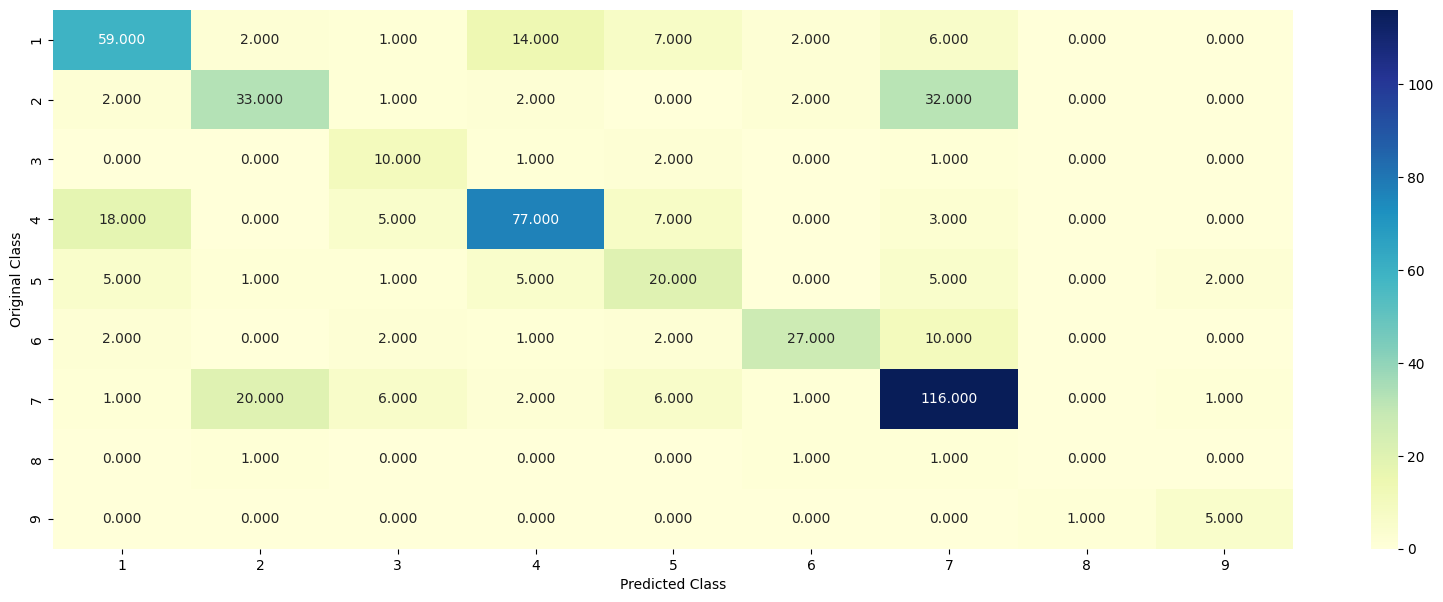

-------------------- Precision matrix (Columm Sum=1) --------------------


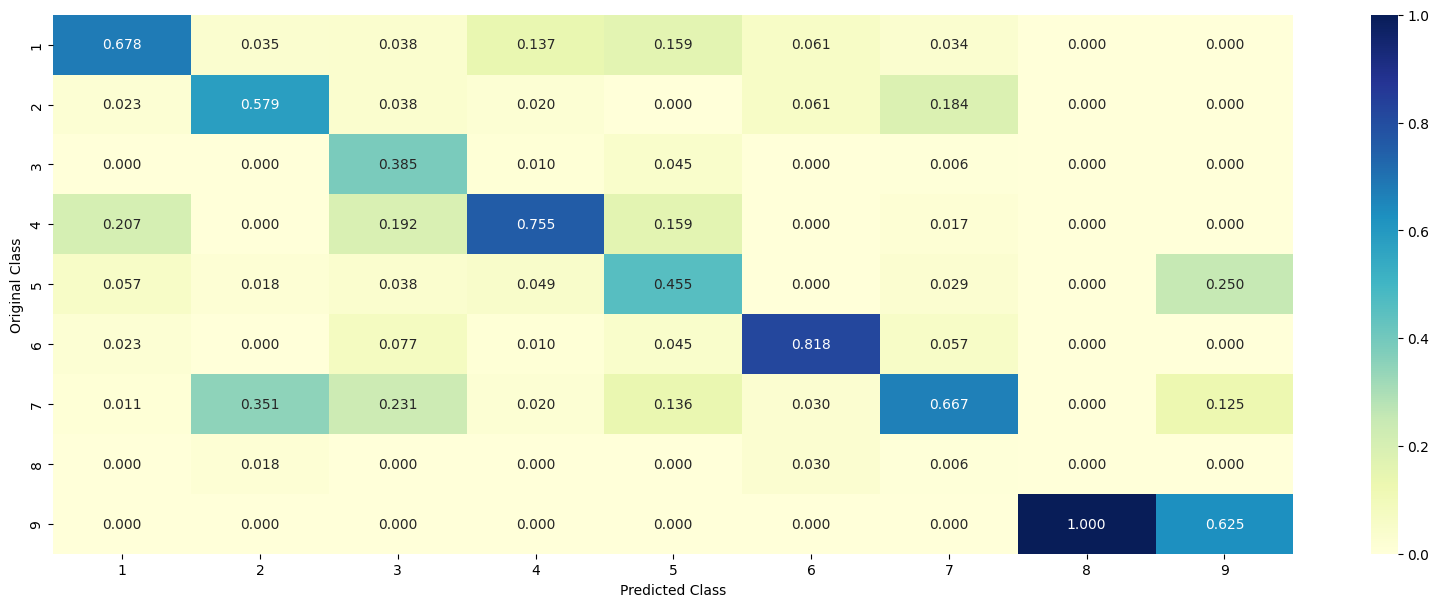

-------------------- Recall matrix (Row sum=1) --------------------


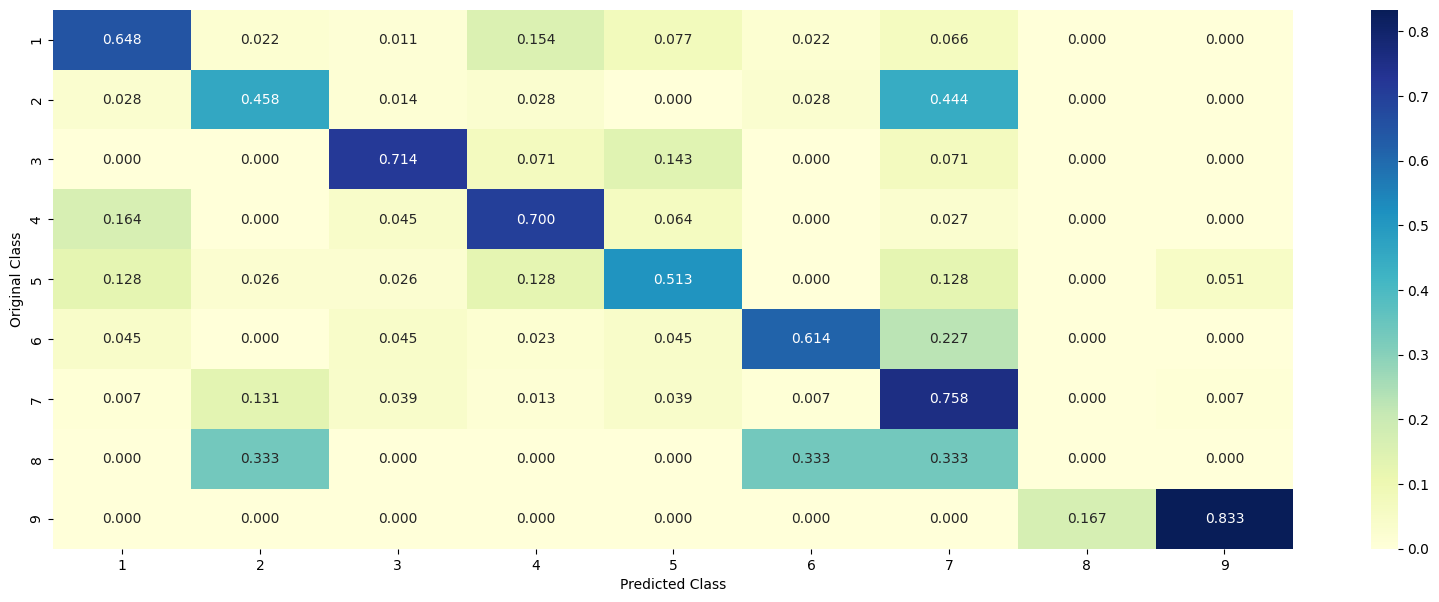

In [ ]:
# Testing model with best hyper parameters

clf = SGDClassifier(alpha =best_alpha, penalty ='l2', loss='hinge', random_state = 42, class_weight ='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [ ]:
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 6
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]


Predicted Class : 1
Predicted Class Probabilities: [[0.4743 0.033  0.0262 0.1138 0.148  0.0265 0.1738 0.0005 0.004 ]]
Actual Class : 4


In [ ]:
test_point_index = 48
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]


Predicted Class : 6
Predicted Class Probabilities: [[0.0707 0.0337 0.0144 0.071  0.0501 0.4455 0.3077 0.0022 0.0047]]
Actual Class : 7


#### TFIDF Features

For alpha = 1e-05
Log Loss: 1.2208317084419622
For alpha = 0.0001
Log Loss: 1.1545110693509602
For alpha = 0.001
Log Loss: 1.0393198787026432
For alpha = 0.01
Log Loss: 1.0787068441979748
For alpha = 0.1
Log Loss: 1.2310447365212673
For alpha = 1
Log Loss: 1.5296375150760635
For alpha = 10
Log Loss: 1.5290977905147687
For alpha = 100
Log Loss: 1.5290977868940712


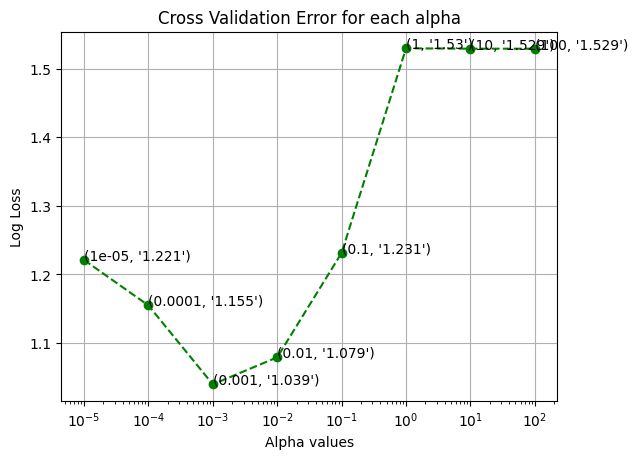

Best Alpha: 0.001
For Train data with alpha=0.001, Log Loss: 0.5241127294717459
For Cross Validation data with alpha=0.001, Log Loss: 1.0393198787026432
For Test data with alpha=0.001, Log Loss: 1.1466063270526445


In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Hinge Loss (Linear SVM)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf)


    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)


    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g', marker='o', linestyle='dashed')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

# Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]

print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf, train_y),
                           ("Cross Validation", cv_tfidf, cv_y),
                           ("Test", test_tfidf, y_test)]:

    predict_y = sig_clf.predict_proba(X)


    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")


Log loss : 1.1466063270526445
Number of mis-classified points : 0.3894736842105263
____________________ Confusion Matrix --------------------


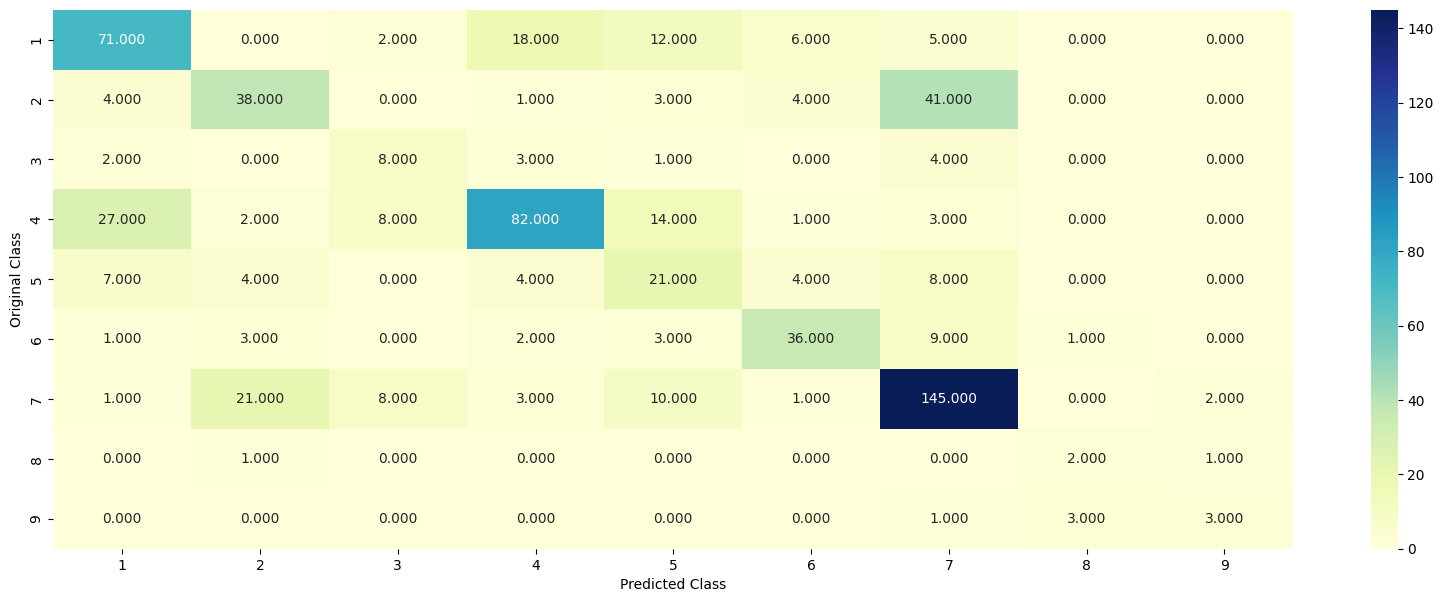

-------------------- Precision matrix (Columm Sum=1) --------------------


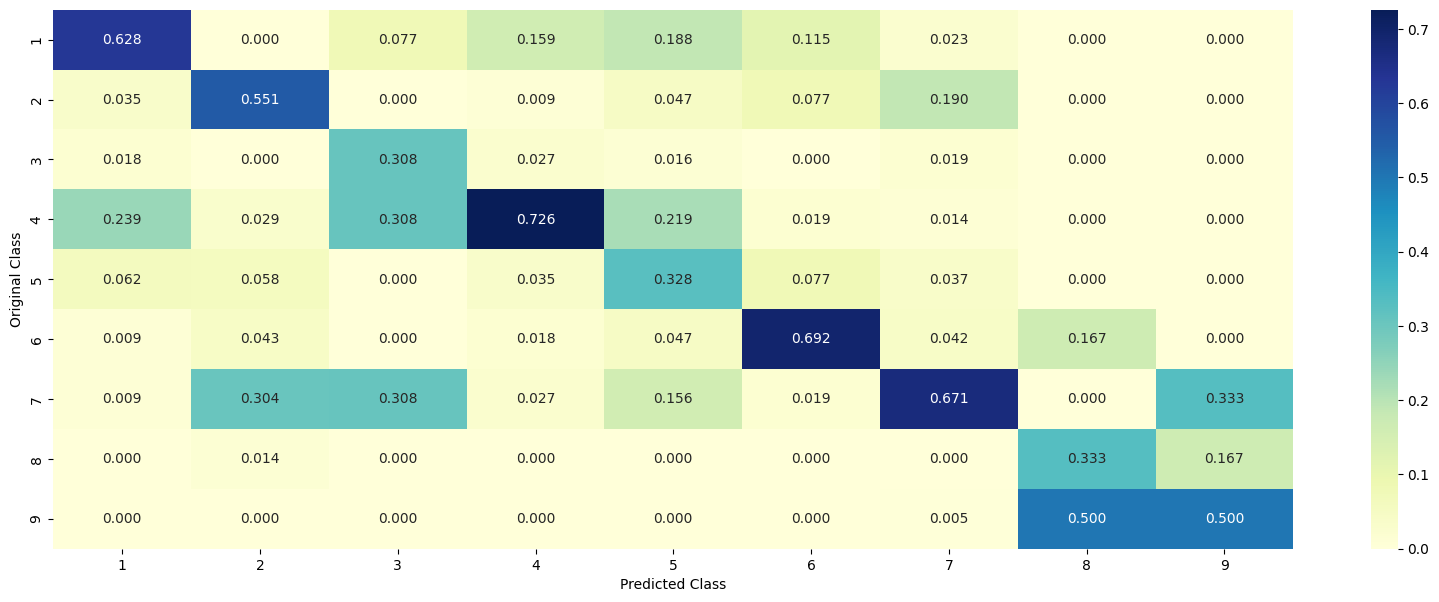

-------------------- Recall matrix (Row sum=1) --------------------


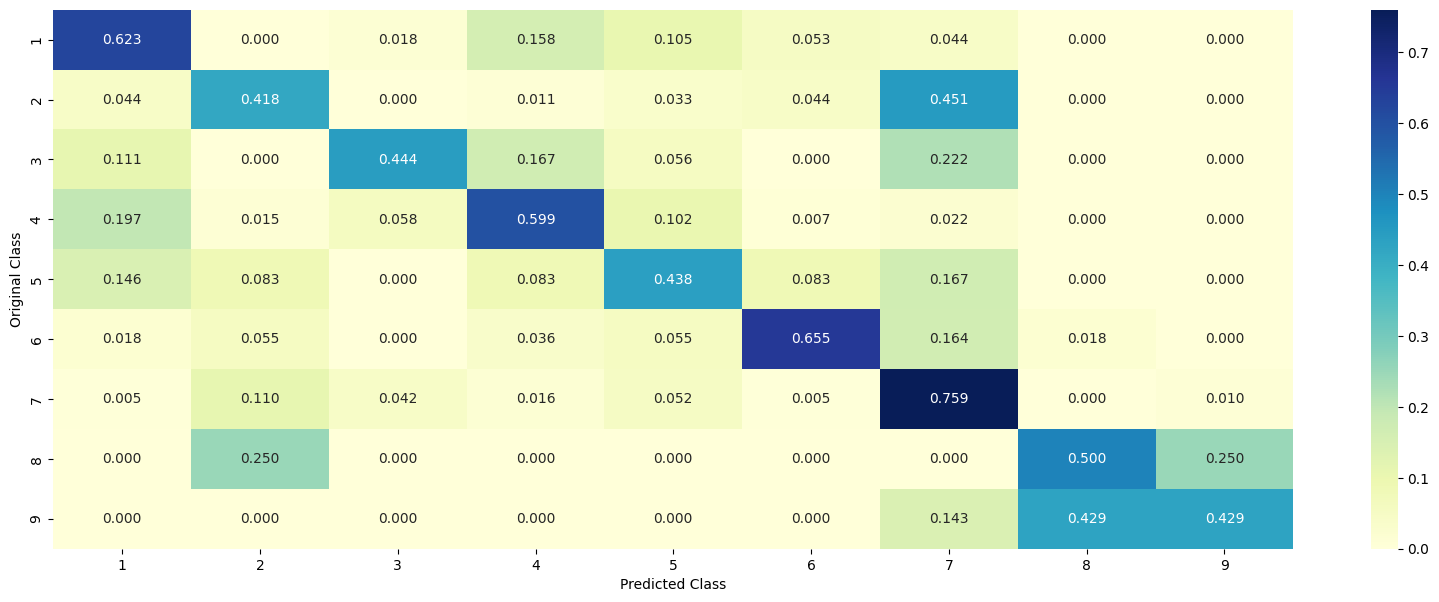

In [ ]:

clf = SGDClassifier(alpha =best_alpha, penalty ='l2', loss='hinge', random_state = 42, class_weight ='balanced')
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_tfidf, test_y, clf)

#### TFIDF with top 1000 features

For alpha = 1e-05
Log Loss: 1.0348862162360222
For alpha = 0.0001
Log Loss: 0.9763238305492071
For alpha = 0.001
Log Loss: 1.0139387645877205
For alpha = 0.01
Log Loss: 1.3344339520335793
For alpha = 0.1
Log Loss: 1.5954146106523635
For alpha = 1
Log Loss: 1.755864796651001
For alpha = 10
Log Loss: 1.7558648155347778
For alpha = 100
Log Loss: 1.755862536625088


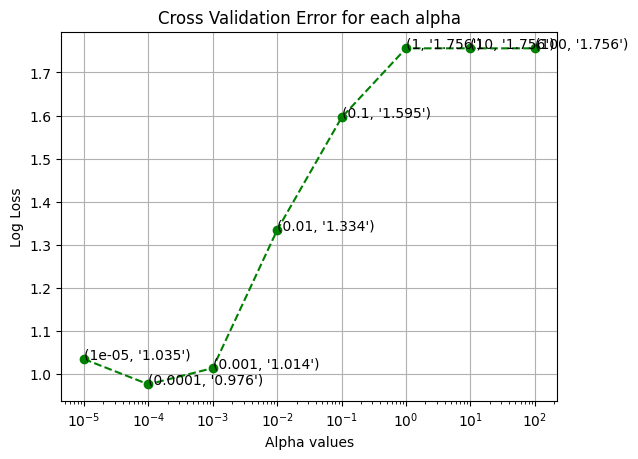

Best Alpha: 0.0001
For Train data with alpha=0.0001, Log Loss: 0.3290592848947082
For Cross Validation data with alpha=0.0001, Log Loss: 0.9763238305492071
For Test data with alpha=0.0001, Log Loss: 1.0577561059348668


In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Hinge Loss (Linear SVM)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf_maxft, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf_maxft, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_maxft)


    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)


    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g', marker='o', linestyle='dashed')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

# Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]

print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf_maxft, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_maxft, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf_maxft, train_y),
                           ("Cross Validation", cv_tfidf_maxft, cv_y),
                           ("Test", test_tfidf_maxft, y_test)]:

    predict_y = sig_clf.predict_proba(X)


    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0577561059348668
Number of mis-classified points : 0.3398496240601504
____________________ Confusion Matrix --------------------


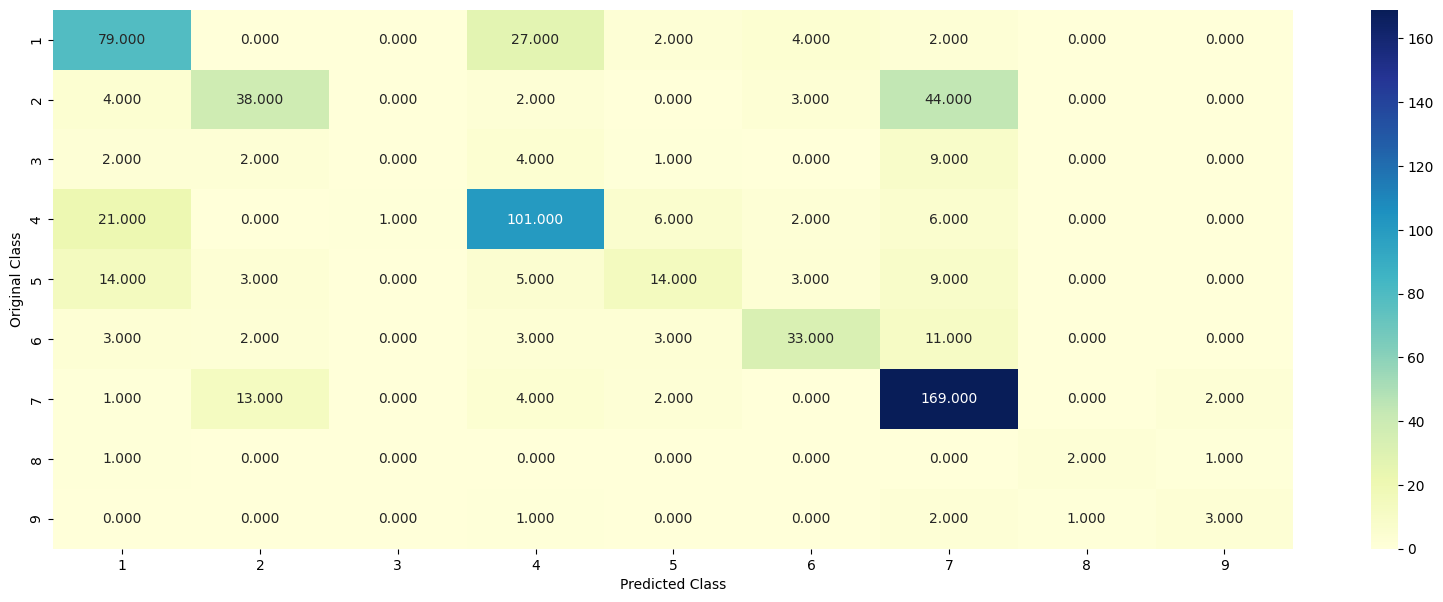

-------------------- Precision matrix (Columm Sum=1) --------------------


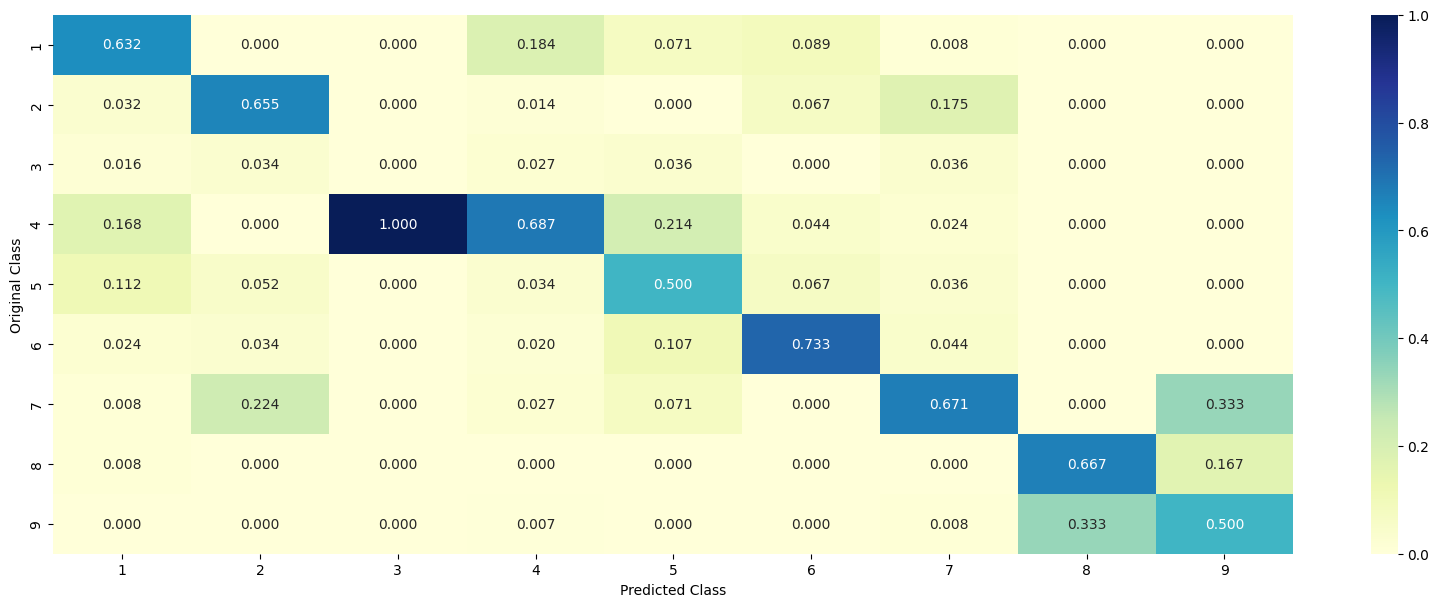

-------------------- Recall matrix (Row sum=1) --------------------


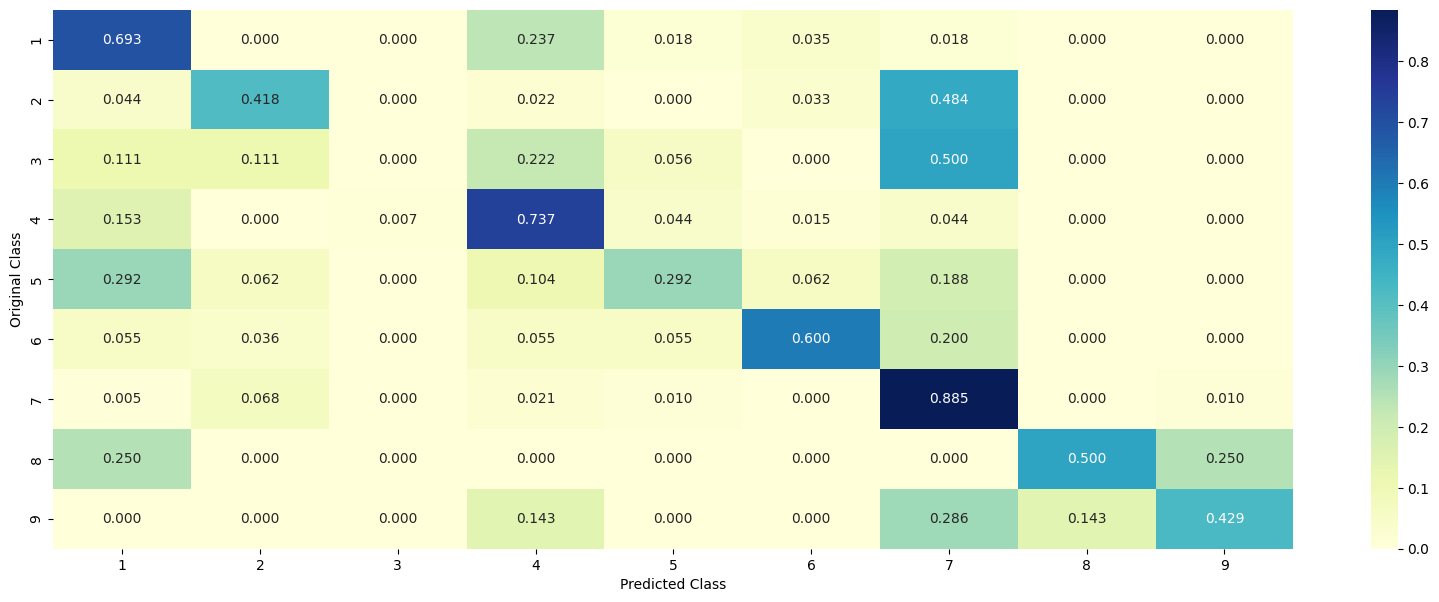

In [ ]:
clf = SGDClassifier(alpha =best_alpha, penalty ='l2', loss='hinge', random_state = 42, class_weight ='balanced')
predict_and_plot_confusion_matrix(train_x_tfidf_maxft, train_y, test_tfidf_maxft, test_y, clf)

# Random Forest Classifier

## Hyper parameter tuning(One hot encoding)

In [ ]:
alphas = [100,200,500,1000,2000]
max_depth_values = [5, 10]
cv_log_error_array = []
param_combinations = []  # Store (n_estimators, max_depth) pairs

# Loop through different hyperparameters
for n_estimators in alphas:
    for max_depth in max_depth_values:
        print(f"For n_estimators = {n_estimators}, max_depth = {max_depth}")
        # Train Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini',
                             max_depth=max_depth, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        # Calibrate the classifier
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        # Predict Probabilities on CV Data
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
        # Compute Log Loss
        log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
        cv_log_error_array.append(log_loss_value)
        param_combinations.append((n_estimators, max_depth))
        print("Log Loss:", log_loss_value)

# Find Best Parameters
best_idx = np.argmin(cv_log_error_array)
best_n_estimators, best_max_depth = param_combinations[best_idx]
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")

# Train Model with Best Parameters
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini',
                             max_depth=best_max_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_onehotCoding, train_y),
                           ("Cross Validation", cv_x_onehotCoding, cv_y),
                           ("Test", test_x_onehotCoding, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with n_estimators={best_n_estimators}, max_depth={best_max_depth}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

For n_estimators = 100, max_depth = 5
Log Loss: 1.2504891581414779
For n_estimators = 100, max_depth = 10
Log Loss: 1.1690795325839858
For n_estimators = 200, max_depth = 5
Log Loss: 1.2456676060706289
For n_estimators = 200, max_depth = 10
Log Loss: 1.1624202546450586
For n_estimators = 500, max_depth = 5
Log Loss: 1.2432395226816702
For n_estimators = 500, max_depth = 10
Log Loss: 1.1566080288032603
For n_estimators = 1000, max_depth = 5
Log Loss: 1.2368912695909664
For n_estimators = 1000, max_depth = 10
Log Loss: 1.1572548470144222
For n_estimators = 2000, max_depth = 5
Log Loss: 1.2342604504032275
For n_estimators = 2000, max_depth = 10
Log Loss: 1.1578941266851912
Best n_estimators: 500, Best max_depth: 10
For Train data with n_estimators=500, max_depth=10, Log Loss: 0.6971736092128769
For Cross Validation data with n_estimators=500, max_depth=10, Log Loss: 1.1566080288032603
For Test data with n_estimators=500, max_depth=10, Log Loss: 1.1944668186529384


Log loss : 1.1944668186529384
Number of mis-classified points : 0.41353383458646614
____________________ Confusion Matrix --------------------


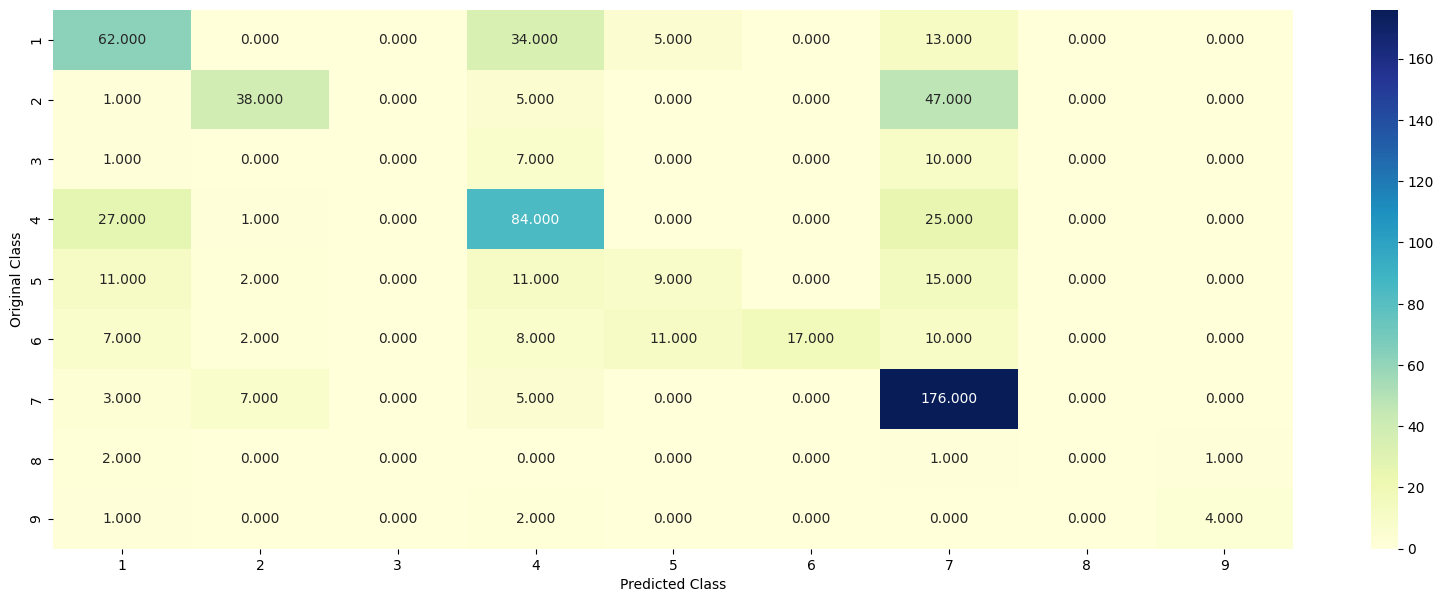

-------------------- Precision matrix (Columm Sum=1) --------------------


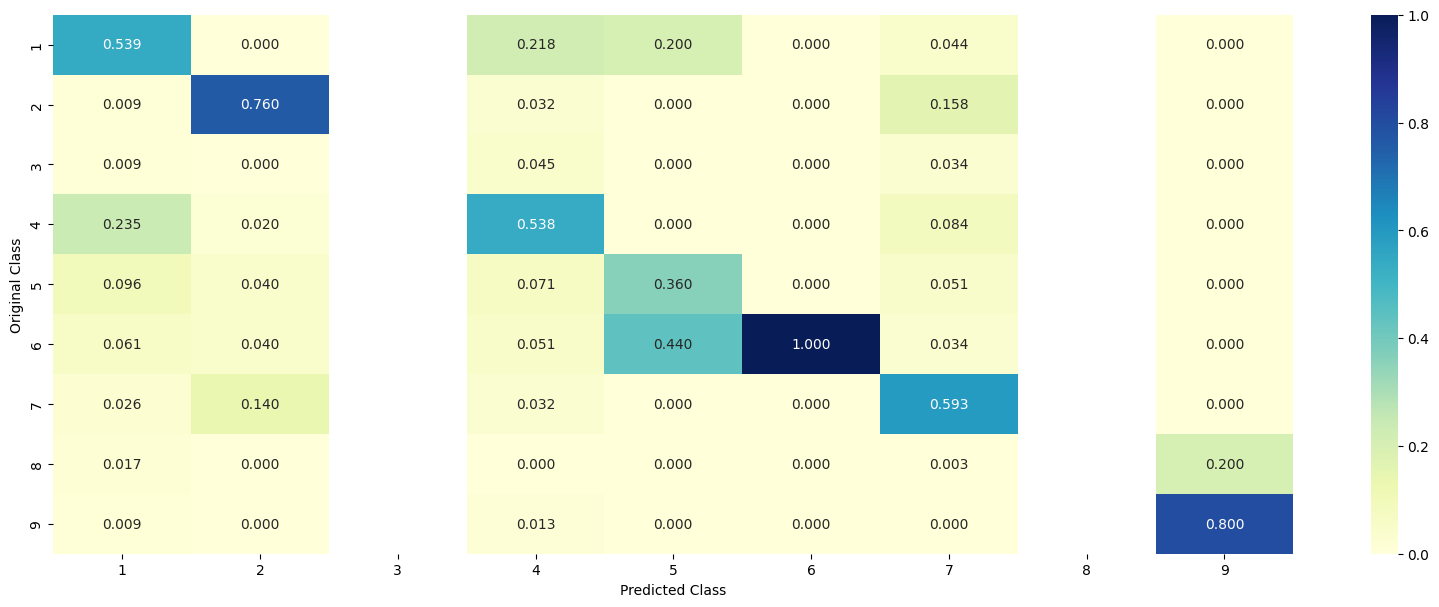

-------------------- Recall matrix (Row sum=1) --------------------


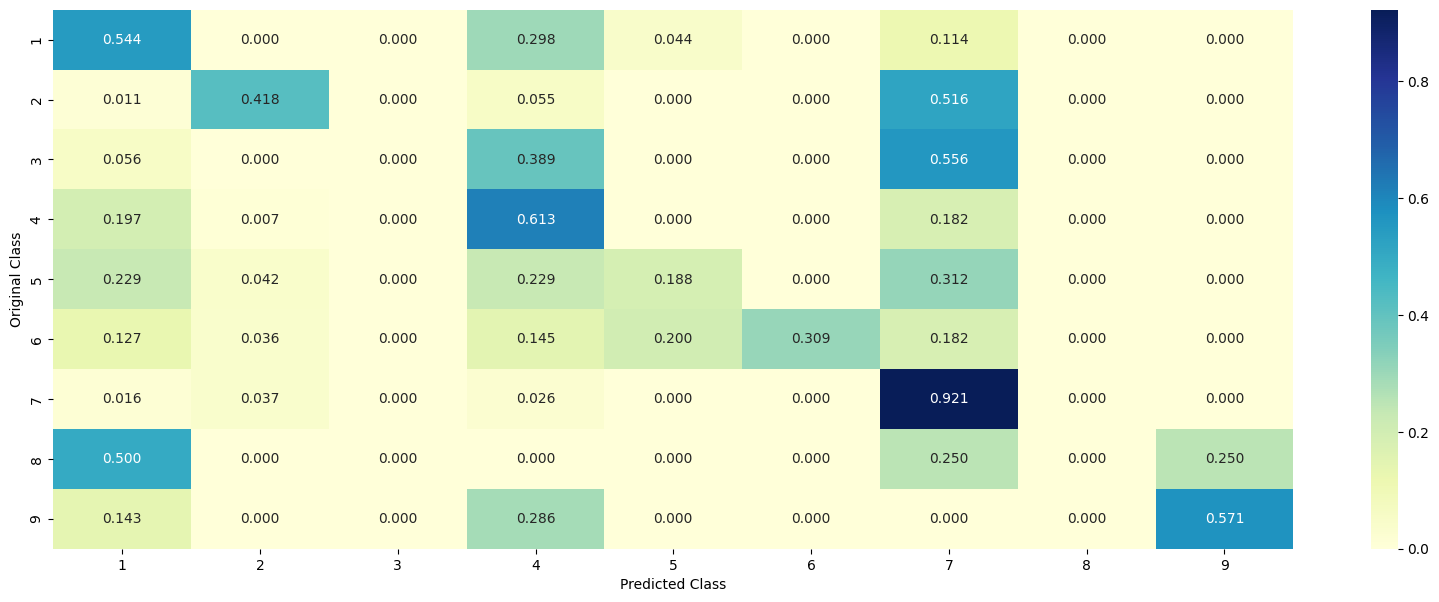

In [ ]:
# Testing model with best hyper parameters (One Hot Encoding)

clf = RandomForestClassifier(n_estimators=best_n_estimators,
                             criterion='gini',
                             max_depth=best_max_depth,
                             random_state=42,
                             n_jobs=1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,test_x_onehotCoding,test_y, clf)

In [ ]:
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini', max_depth=best_max_depth, random_state=42, n_jobs=1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)


Predicted Class : 1
Predicted Class Probabilities: [[0.2702 0.1688 0.028  0.1949 0.0637 0.0579 0.1949 0.0097 0.0119]]
Actual Class : 6


In [ ]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)


Predicted Class : 4
Predicted Class Probabilities: [[0.1398 0.0145 0.0394 0.6503 0.0867 0.0372 0.0223 0.0047 0.0051]]
Actuall Class : 4
--------------------------------------------------


#### TFIDF Features

In [ ]:
alphas = [100,200,500,1000,2000]
max_depth_values = [5, 10]
cv_log_error_array = []
param_combinations = []  # Store (n_estimators, max_depth) pairs

# Loop through different hyperparameters
for n_estimators in alphas:
    for max_depth in max_depth_values:
        print(f"For n_estimators = {n_estimators}, max_depth = {max_depth}")
        # Train Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini',
                             max_depth=max_depth, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        # Calibrate the classifier
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        # Predict Probabilities on CV Data
        sig_clf_probs = sig_clf.predict_proba(cv_tfidf)
        sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
        # Compute Log Loss
        log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
        cv_log_error_array.append(log_loss_value)
        param_combinations.append((n_estimators, max_depth))
        print("Log Loss:", log_loss_value)

# Find Best Parameters
best_idx = np.argmin(cv_log_error_array)
best_n_estimators, best_max_depth = param_combinations[best_idx]
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")

# Train Model with Best Parameters
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini',
                             max_depth=best_max_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf, train_y),
                           ("Cross Validation", cv_tfidf, cv_y),
                           ("Test", test_tfidf, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with n_estimators={best_n_estimators}, max_depth={best_max_depth}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

For n_estimators = 100, max_depth = 5
Log Loss: 1.2518805465552696
For n_estimators = 100, max_depth = 10
Log Loss: 1.1716854699199541
For n_estimators = 200, max_depth = 5
Log Loss: 1.2316617036864277
For n_estimators = 200, max_depth = 10
Log Loss: 1.1589737999523977
For n_estimators = 500, max_depth = 5
Log Loss: 1.215900546137149
For n_estimators = 500, max_depth = 10
Log Loss: 1.149310084128062
For n_estimators = 1000, max_depth = 5
Log Loss: 1.2116514054057523
For n_estimators = 1000, max_depth = 10
Log Loss: 1.1504275252207268
For n_estimators = 2000, max_depth = 5
Log Loss: 1.209816036730695
For n_estimators = 2000, max_depth = 10
Log Loss: 1.1500674310012329
Best n_estimators: 500, Best max_depth: 10
For Train data with n_estimators=500, max_depth=10, Log Loss: 0.6511421834009045
For Cross Validation data with n_estimators=500, max_depth=10, Log Loss: 1.149310084128062
For Test data with n_estimators=500, max_depth=10, Log Loss: 1.1304801458420504


Log loss : 1.1304801458420504
Number of mis-classified points : 0.3894736842105263
____________________ Confusion Matrix --------------------


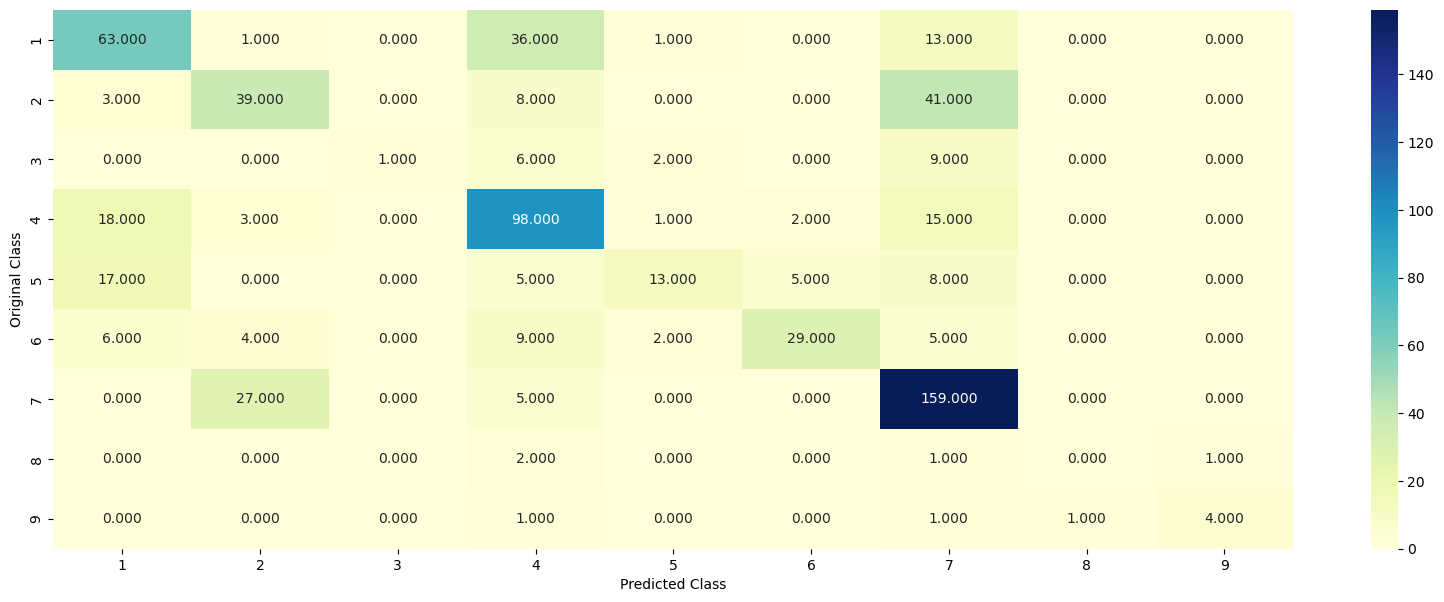

-------------------- Precision matrix (Columm Sum=1) --------------------


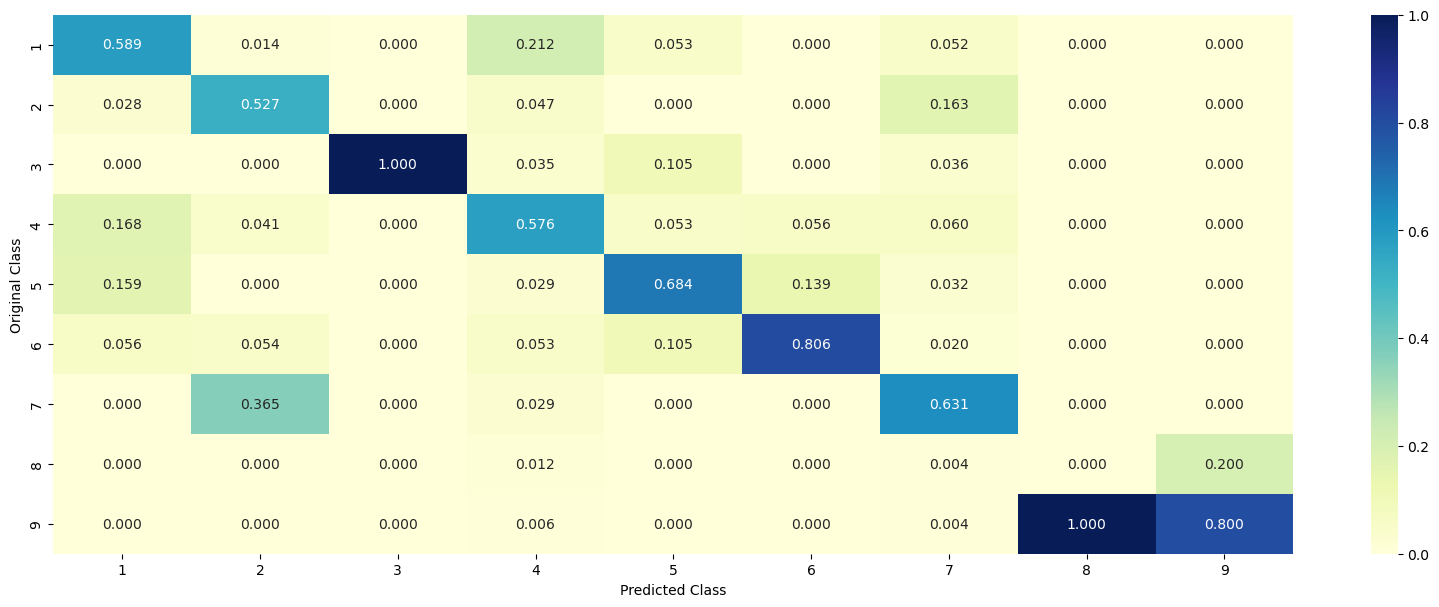

-------------------- Recall matrix (Row sum=1) --------------------


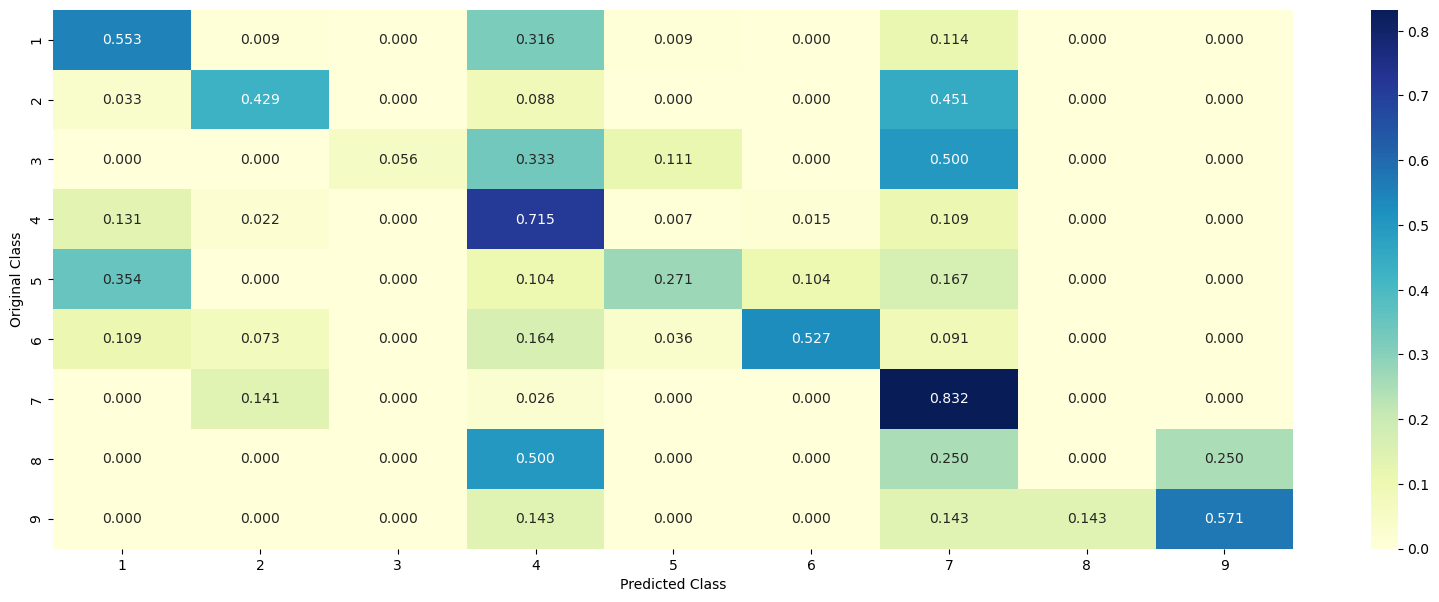

In [ ]:
clf = RandomForestClassifier(n_estimators=best_n_estimators,
                             criterion='gini',
                             max_depth=best_max_depth,
                             random_state=42,
                             n_jobs=1)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y,test_tfidf,test_y, clf)

### TFIDF with top 1000 features

In [ ]:
alphas = [100,200,500,1000,2000]
max_depth_values = [5, 10]
cv_log_error_array = []
param_combinations = []  # Store (n_estimators, max_depth) pairs

# Loop through different hyperparameters
for n_estimators in alphas:
    for max_depth in max_depth_values:
        print(f"For n_estimators = {n_estimators}, max_depth = {max_depth}")
        # Train Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini',
                             max_depth=max_depth, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf_maxft, train_y)
        # Calibrate the classifier
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf_maxft, train_y)
        # Predict Probabilities on CV Data
        sig_clf_probs = sig_clf.predict_proba(cv_tfidf_maxft)
        sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
        # Compute Log Loss
        log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
        cv_log_error_array.append(log_loss_value)
        param_combinations.append((n_estimators, max_depth))
        print("Log Loss:", log_loss_value)

# Find Best Parameters
best_idx = np.argmin(cv_log_error_array)
best_n_estimators, best_max_depth = param_combinations[best_idx]
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")

# Train Model with Best Parameters
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini',
                             max_depth=best_max_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf_maxft, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_maxft, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf_maxft, train_y),
                           ("Cross Validation", cv_tfidf_maxft, cv_y),
                           ("Test", test_tfidf_maxft, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with n_estimators={best_n_estimators}, max_depth={best_max_depth}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

For n_estimators = 100, max_depth = 5
Log Loss: 1.221314525133759
For n_estimators = 100, max_depth = 10
Log Loss: 1.2487895811644225
For n_estimators = 200, max_depth = 5
Log Loss: 1.2173490599647039
For n_estimators = 200, max_depth = 10
Log Loss: 1.2360194003405343
For n_estimators = 500, max_depth = 5
Log Loss: 1.2148149337310565
For n_estimators = 500, max_depth = 10
Log Loss: 1.2349468031242532
For n_estimators = 1000, max_depth = 5
Log Loss: 1.2116807285899172
For n_estimators = 1000, max_depth = 10
Log Loss: 1.2311579664871004
For n_estimators = 2000, max_depth = 5
Log Loss: 1.2126598245376365
For n_estimators = 2000, max_depth = 10
Log Loss: 1.2314737262297082
Best n_estimators: 1000, Best max_depth: 5
For Train data with n_estimators=1000, max_depth=5, Log Loss: 0.8608168712220825
For Cross Validation data with n_estimators=1000, max_depth=5, Log Loss: 1.2116807285899172
For Test data with n_estimators=1000, max_depth=5, Log Loss: 1.1925776526838106


Log loss : 1.1925776526838103
Number of mis-classified points : 0.44511278195488724
____________________ Confusion Matrix --------------------


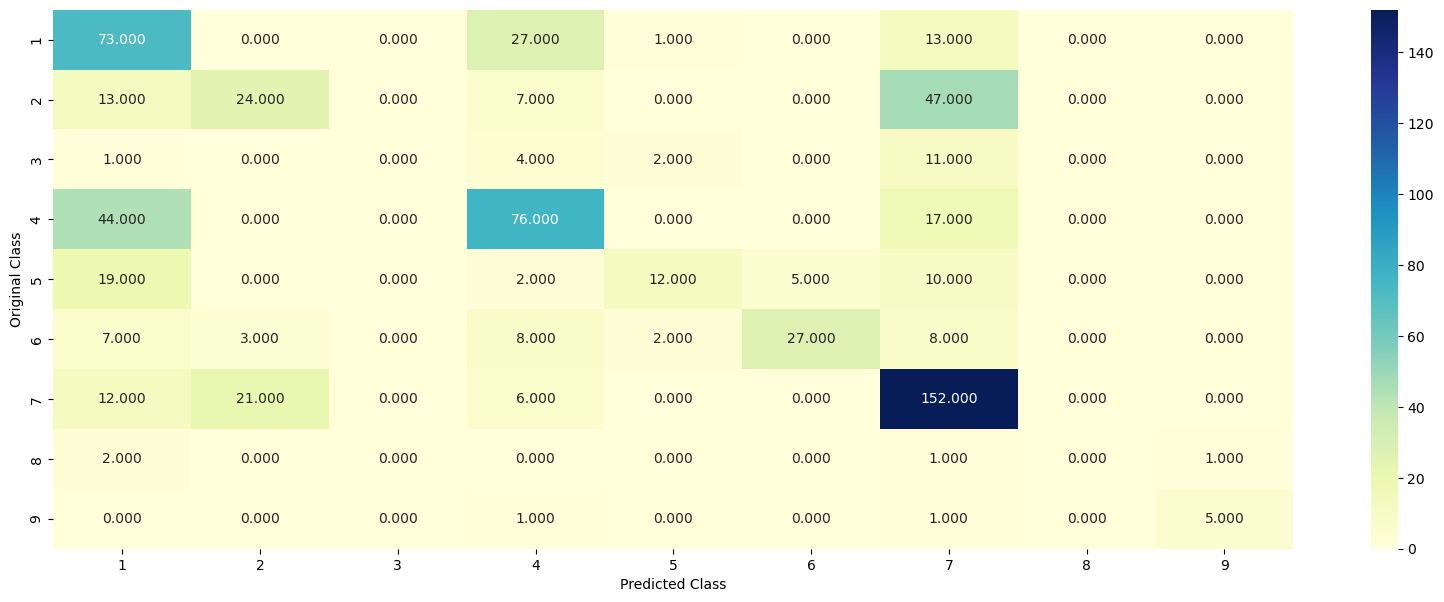

-------------------- Precision matrix (Columm Sum=1) --------------------


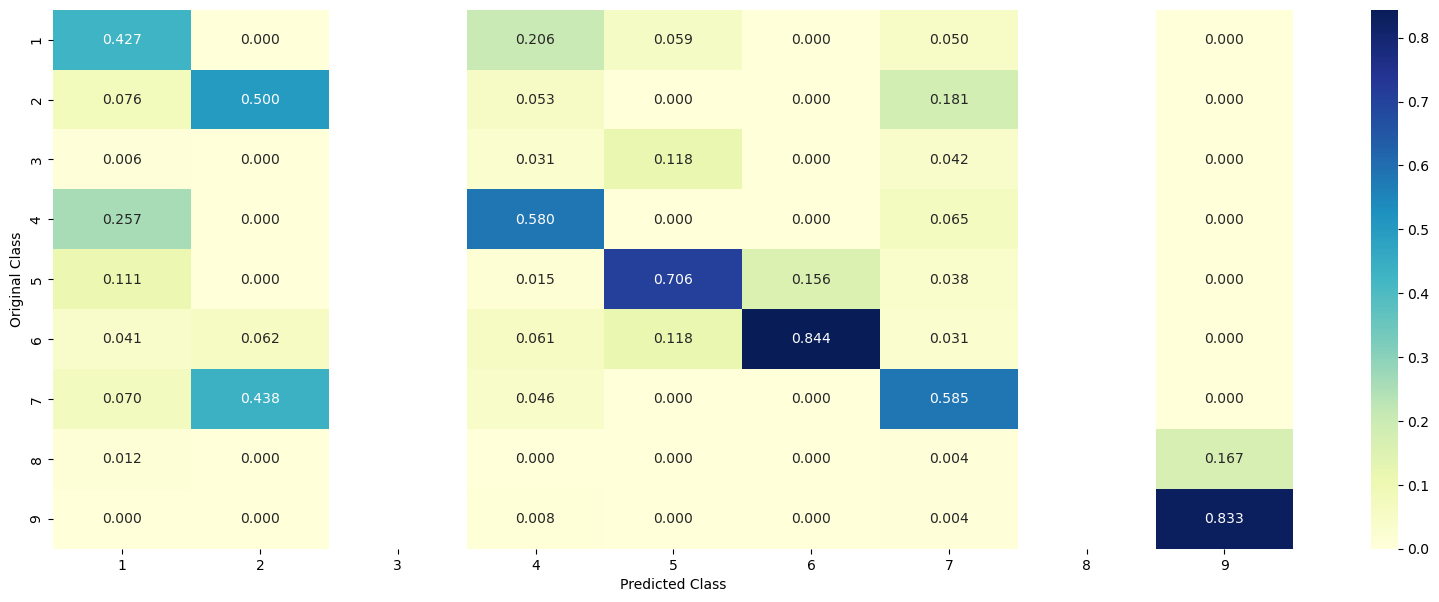

-------------------- Recall matrix (Row sum=1) --------------------


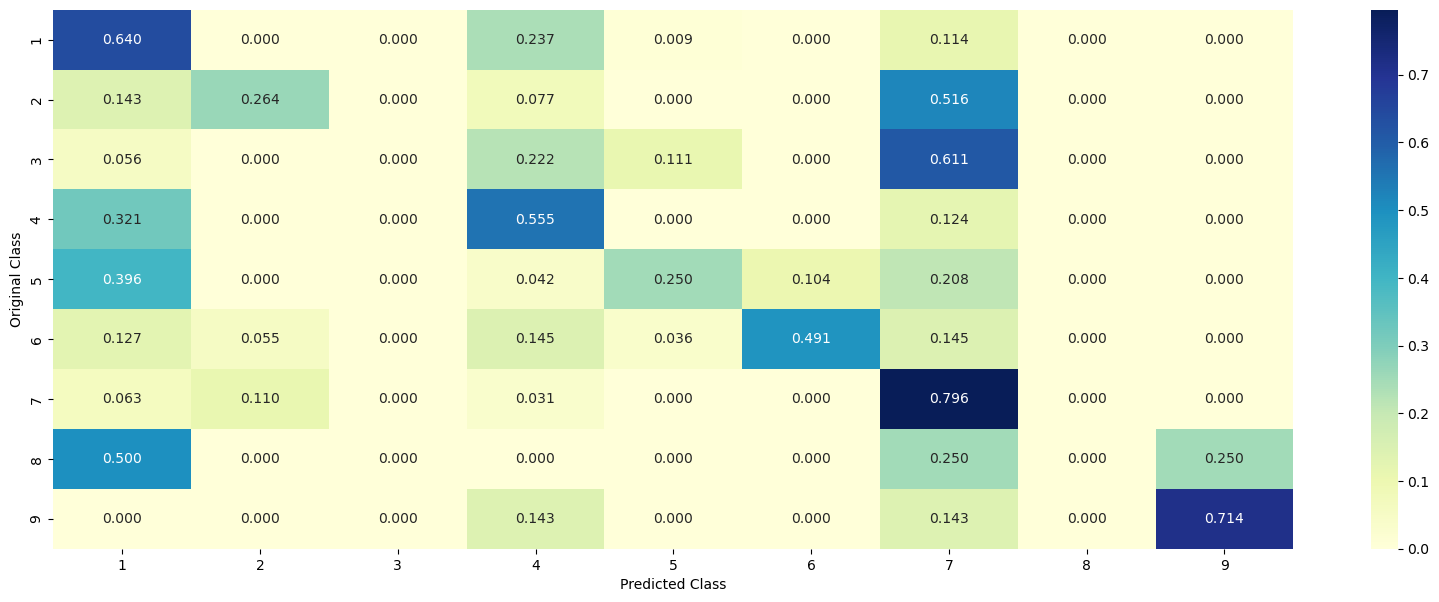

In [ ]:
clf = RandomForestClassifier(n_estimators=best_n_estimators,
                             criterion='gini',
                             max_depth=best_max_depth,
                             random_state=42,
                             n_jobs=1)
predict_and_plot_confusion_matrix(train_x_tfidf_maxft,train_y,test_tfidf_maxft,test_y, clf)